# TESS Atlas fit for TOI 121

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 121.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-121.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-121.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-121.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 121

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 121 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

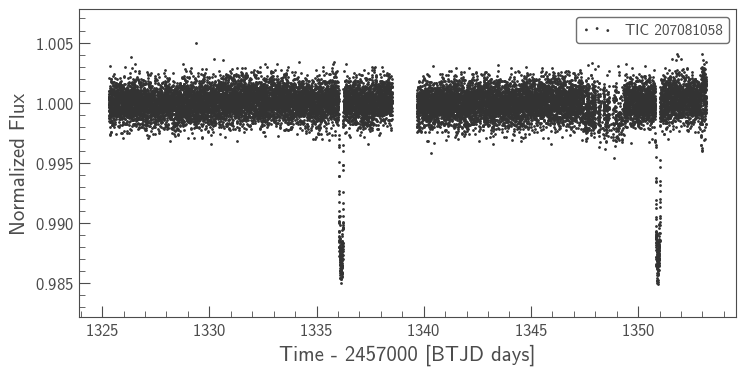

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -32748.931629009683 -> -32529.49895433897


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -27891.516254537226 -> -27335.719803910757


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -27335.719803910757 -> -25962.415033144447


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -25962.415033144447 -> -25918.77484495466


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -25918.77484495466 -> -25917.761325004853


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -25917.761325004853 -> -25914.719641024487


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -25914.719641024487 -> -25741.083967730276


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']
message: Optimization terminated successfully.
logp: -25741.08396773028 -> -25741.08396773028


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -25741.083967730276 -> -25741.083967730276


optimizing logp for variables: ['logg_star']
message: Optimization terminated successfully.
logp: -25741.083967730276 -> -25741.083967730276


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -25741.083967730276 -> -25741.083967730276


optimizing logp for variables: ['mean', 'rb_radiusimpact__']
message: Optimization terminated successfully.
logp: -25741.083967730276 -> -25741.083967730276


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -25741.083967730276 -> -25741.083967730276


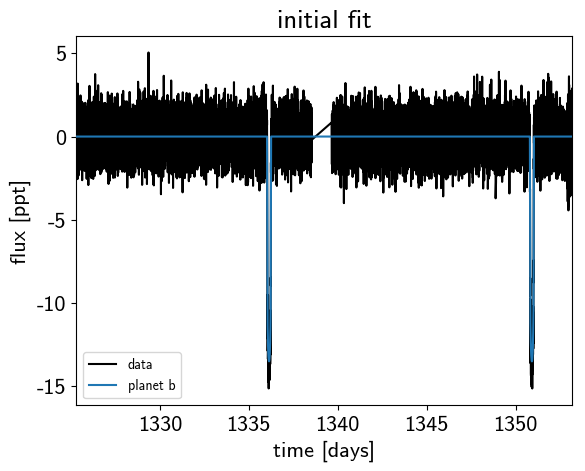

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:05, 16.39draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:10,  8.71draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:14,  6.41draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:23,  3.92draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:19,  4.66draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:23,  3.82draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:26,  3.30draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:26,  3.34draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:23,  3.66draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:23,  3.64draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:28,  2.95draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:25,  3.21draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:29,  2.74draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:26,  3.08draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:24,  3.25draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:28,  2.76draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:27,  2.78draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:22,  3.41draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:26,  2.84draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:23,  3.09draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:21,  3.37draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:25,  2.82draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:22,  3.11draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:22,  3.11draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:18,  3.62draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:22,  2.92draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:20,  3.21draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:10<00:16,  3.86draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:18,  3.49draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:10<00:15,  4.01draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:16,  3.74draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:18,  3.21draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:17,  3.36draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:12<00:15,  3.58draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:15,  3.54draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:13,  3.97draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:14,  3.74draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:12,  4.06draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:15,  3.30draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:12,  3.93draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:14<00:13,  3.58draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:14<00:11,  4.15draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:12,  3.78draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:10,  4.30draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:11,  3.92draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:15<00:10,  4.33draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:12,  3.40draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:16<00:11,  3.47draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:16<00:10,  3.86draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:10,  3.74draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:17<00:12,  3.08draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:17<00:10,  3.32draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:09,  3.54draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:18<00:09,  3.73draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:18<00:10,  3.04draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:19<00:09,  3.32draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:19<00:07,  4.07draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:19<00:08,  3.62draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:19<00:06,  4.34draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:20<00:07,  3.81draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:20<00:05,  4.49draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:20<00:06,  3.93draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:20<00:05,  4.40draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:20<00:05,  4.04draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:21<00:04,  4.44draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:21<00:05,  3.76draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:21<00:04,  4.07draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:21<00:04,  3.94draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:22<00:05,  3.28draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:22<00:04,  3.41draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:23<00:03,  3.92draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:23<00:05,  2.57draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:24<00:06,  2.09draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:24<00:05,  2.32draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:25<00:04,  2.43draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:25<00:04,  2.03draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:26<00:04,  1.82draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:27<00:04,  1.70draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:27<00:04,  1.63draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:28<00:03,  1.58draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:29<00:03,  1.54draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:29<00:02,  1.53draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:30<00:01,  1.52draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:31<00:01,  1.52draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:31<00:00,  1.60draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:34<00:00,  1.22s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:04, 21.67draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:00<00:09,  9.82draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:12,  7.09draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:01<00:14,  5.92draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:16,  5.21draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:02<00:16,  4.91draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:03<00:17,  4.71draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:03<00:15,  5.10draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:04<00:13,  5.43draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:04<00:14,  4.99draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:05<00:14,  4.76draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:05<00:13,  5.14draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:05<00:10,  6.45draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:06<00:13,  4.77draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:06<00:11,  5.37draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:06<00:14,  4.35draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:06<00:13,  4.75draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:07<00:14,  4.16draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:07<00:13,  4.58draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:07<00:14,  4.14draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:07<00:12,  4.50draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:08<00:11,  5.04draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:08<00:10,  5.06draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:08<00:11,  4.57draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:08<00:09,  5.43draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:08<00:10,  4.80draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:09<00:10,  4.82draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:09<00:10,  4.50draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:09<00:10,  4.54draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:09<00:10,  4.39draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:10<00:10,  4.43draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:10<00:10,  4.35draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:10<00:10,  4.35draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:10<00:09,  4.34draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:11<00:09,  4.31draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:11<00:09,  4.32draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:11<00:09,  4.25draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:11<00:09,  4.30draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:11<00:08,  4.24draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:12<00:07,  5.06draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:12<00:07,  4.64draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:12<00:07,  4.72draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:12<00:07,  4.39draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:13<00:06,  4.58draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:13<00:05,  5.17draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:13<00:05,  5.10draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:13<00:06,  4.61draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:14<00:04,  5.51draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:14<00:05,  4.73draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:14<00:04,  4.89draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:14<00:05,  4.11draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:15<00:04,  4.50draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:15<00:05,  4.11draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:15<00:04,  4.48draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:15<00:04,  4.10draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:15<00:03,  5.08draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:16<00:03,  4.34draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:16<00:03,  4.79draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:16<00:03,  4.17draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:16<00:03,  4.30draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:17<00:02,  4.02draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:17<00:02,  4.41draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:17<00:02,  4.07draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:17<00:02,  4.48draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:18<00:01,  4.08draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:18<00:01,  4.50draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:18<00:01,  4.07draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:18<00:01,  4.52draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:19<00:00,  4.07draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:19<00:00,  4.53draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:19<00:00,  4.29draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:20<00:00,  1.68draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:21<00:00,  1.86draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:48,  1.87draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:18,  2.55draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:10,  2.82draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<01:03,  3.13draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:50,  3.89draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<00:56,  3.47draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:41,  4.60draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:02<00:43,  4.42draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:38,  4.93draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:03<00:30,  6.05draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:03<00:24,  7.55draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:03<00:20,  9.06draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:03<00:17, 10.55draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:03<00:17, 10.16draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:03<00:17, 10.22draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:04<00:15, 11.42draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:04<00:13, 12.64draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:04<00:19,  8.72draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:05<00:25,  6.67draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:05<00:26,  6.46draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:05<00:33,  5.02draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:05<00:28,  5.73draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:06<00:25,  6.32draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:06<00:30,  5.19draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:06<00:22,  6.83draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:07<00:22,  6.85draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:07<00:21,  7.03draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:07<00:25,  5.84draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:08<00:23,  6.32draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:08<00:22,  6.48draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:08<00:20,  7.20draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:08<00:24,  5.86draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:08<00:20,  6.89draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:09<00:21,  6.48draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:09<00:20,  6.74draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:09<00:19,  7.16draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:09<00:23,  5.76draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:09<00:21,  6.52draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:10<00:17,  7.64draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:10<00:14,  8.94draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:10<00:19,  6.60draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:10<00:23,  5.53draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:11<00:22,  5.75draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:11<00:23,  5.46draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:11<00:17,  7.10draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:12<00:18,  6.39draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:12<00:15,  7.42draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:12<00:14,  8.04draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:13<00:16,  6.99draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:13<00:16,  6.63draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:13<00:15,  7.01draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:13<00:14,  7.71draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:14<00:16,  6.41draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:14<00:15,  6.85draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:14<00:14,  7.18draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:14<00:14,  7.15draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:14<00:11,  8.62draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:15<00:09,  9.67draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:15<00:08, 11.02draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:15<00:08, 10.95draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:15<00:06, 12.73draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:15<00:06, 13.00draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:16<00:08,  9.77draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:16<00:07, 10.88draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:16<00:07, 11.00draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:16<00:06, 11.49draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:16<00:06, 12.66draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:16<00:05, 12.62draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:17<00:06, 11.01draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:17<00:06,  9.92draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:17<00:07,  9.41draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:17<00:06, 10.04draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:18<00:06,  9.33draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:18<00:07,  8.21draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:18<00:08,  6.89draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:18<00:06,  8.87draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:19<00:05,  9.42draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:19<00:07,  6.72draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:19<00:07,  6.88draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:20<00:10,  4.69draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:20<00:10,  4.86draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:20<00:09,  5.19draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:20<00:08,  5.23draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:21<00:07,  6.07draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:21<00:05,  7.49draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:21<00:06,  6.63draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:21<00:04,  8.46draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:21<00:04,  8.46draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:22<00:03,  9.84draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:22<00:02, 10.53draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:22<00:02, 10.25draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:22<00:02, 11.03draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:22<00:02,  9.97draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:23<00:02,  8.19draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:23<00:01, 10.07draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:23<00:01,  9.04draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:23<00:01,  8.96draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:24<00:02,  5.62draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:24<00:03,  3.87draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:25<00:03,  3.43draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:25<00:02,  3.43draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:25<00:02,  3.62draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:26<00:02,  3.28draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:26<00:02,  3.09draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:27<00:02,  2.60draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:27<00:01,  3.25draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:27<00:01,  3.46draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:27<00:01,  2.88draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:28<00:00,  3.06draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:28<00:00,  3.77draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:28<00:00,  3.55draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:06, 59.52draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:12, 32.85draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:15, 25.19draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:17, 22.64draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:00<00:16, 22.77draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:00<00:25, 14.81draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:01<00:26, 14.68draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:01<00:22, 16.90draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:01<00:28, 13.07draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:01<00:35, 10.69draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:01<00:33, 10.98draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:02<00:28, 12.90draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:02<00:24, 15.05draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:02<00:18, 19.31draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:02<00:15, 23.03draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:02<00:14, 24.78draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:02<00:14, 23.77draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:02<00:13, 24.74draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:03<00:20, 16.87draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:03<00:20, 16.73draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:03<00:22, 15.17draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:03<00:19, 17.06draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:03<00:15, 20.70draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:03<00:12, 24.92draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:04<00:11, 27.74draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:04<00:16, 18.53draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:04<00:23, 13.44draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:04<00:22, 13.94draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:05<00:24, 12.59draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:05<00:22, 13.47draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:05<00:18, 16.29draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:05<00:15, 19.19draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:05<00:12, 23.56draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:05<00:11, 25.37draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:05<00:11, 25.32draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:06<00:11, 23.27draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:06<00:10, 25.12draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:06<00:11, 23.68draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:06<00:09, 26.98draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:06<00:15, 16.47draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:07<00:16, 16.23draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:07<00:18, 13.64draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:07<00:18, 13.63draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:07<00:19, 13.23draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:07<00:16, 15.26draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:08<00:19, 12.86draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:08<00:16, 14.96draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:08<00:19, 12.59draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:08<00:17, 13.58draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:09<00:26,  8.88draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:09<00:21, 10.95draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:09<00:19, 11.98draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:09<00:17, 13.58draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:09<00:13, 16.90draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:09<00:12, 17.40draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:09<00:13, 16.76draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:10<00:11, 18.27draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:10<00:11, 19.32draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:10<00:11, 18.24draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:10<00:13, 15.99draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:10<00:11, 17.56draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:10<00:12, 16.26draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:11<00:13, 14.51draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:11<00:16, 12.03draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:11<00:16, 11.99draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:11<00:14, 13.13draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:11<00:13, 14.45draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:11<00:10, 17.44draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:12<00:09, 19.00draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:12<00:08, 22.21draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:12<00:08, 21.25draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:12<00:08, 20.50draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:12<00:09, 18.62draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:12<00:09, 16.91draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:12<00:09, 17.59draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:13<00:09, 16.57draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:13<00:09, 17.71draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:13<00:07, 19.89draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:13<00:07, 20.46draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:13<00:06, 23.56draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:13<00:05, 24.59draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:13<00:05, 25.74draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:13<00:05, 27.60draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [00:14<00:04, 27.79draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:14<00:05, 24.96draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:14<00:05, 23.89draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:14<00:06, 20.22draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:14<00:06, 19.29draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:14<00:06, 19.55draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:15<00:05, 20.13draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:15<00:05, 21.40draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:15<00:05, 20.62draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:15<00:05, 18.58draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:15<00:05, 18.66draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:15<00:05, 20.74draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:15<00:04, 22.57draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:16<00:04, 22.07draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:16<00:04, 20.75draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:16<00:04, 22.09draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:16<00:04, 18.01draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:16<00:05, 16.62draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:17<00:07, 11.50draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:17<00:08,  9.36draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:17<00:11,  6.74draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:17<00:11,  6.74draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:18<00:11,  6.79draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:18<00:11,  6.89draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:18<00:10,  7.22draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:18<00:09,  7.81draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:18<00:07,  9.48draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:18<00:06, 10.39draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:18<00:06, 10.74draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:19<00:12,  5.26draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:19<00:12,  5.31draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [00:20<00:13,  4.97draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:20<00:13,  4.89draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:20<00:11,  5.70draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:20<00:11,  5.32draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [00:20<00:09,  6.15draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:20<00:08,  6.86draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:21<00:06,  8.54draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:21<00:05, 10.20draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:21<00:04, 11.86draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:21<00:04, 11.95draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:21<00:03, 13.49draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:21<00:04, 10.89draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:22<00:05,  7.84draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:22<00:06,  6.55draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:22<00:07,  5.88draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:22<00:06,  6.67draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:23<00:05,  7.33draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:23<00:05,  7.92draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:23<00:04,  8.08draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:23<00:03,  9.70draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:23<00:03,  9.56draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:23<00:03,  9.84draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:24<00:03,  7.85draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:24<00:03,  8.56draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:24<00:03,  7.65draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:24<00:03,  8.21draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:24<00:03,  6.90draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:24<00:03,  6.99draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:25<00:03,  6.97draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:25<00:03,  7.30draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:25<00:03,  6.65draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:25<00:02,  6.83draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:25<00:02,  6.93draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:25<00:02,  7.29draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:25<00:02,  7.89draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:26<00:01,  9.49draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:26<00:01,  8.52draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:26<00:01,  8.29draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:26<00:01,  7.68draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:26<00:01,  7.33draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:26<00:01,  7.23draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:27<00:01,  7.08draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:27<00:00,  7.02draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:27<00:00,  8.27draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:27<00:00,  6.33draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:27<00:00,  6.77draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:27<00:00,  7.24draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:27<00:00,  7.88draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:16, 48.61draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:16, 47.66draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:00<00:24, 31.70draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:27, 28.47draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:31, 24.78draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:00<00:33, 23.54draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:00<00:34, 22.57draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:01<00:35, 22.04draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:01<00:40, 19.25draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:01<00:43, 17.81draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:01<00:36, 21.25draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:01<00:31, 23.97draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:01<00:31, 24.28draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:02<00:35, 21.43draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:02<00:46, 16.00draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:02<00:46, 16.14draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:02<00:48, 15.32draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:02<00:48, 15.31draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:02<00:48, 15.33draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:02<00:46, 16.10draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:03<00:38, 19.39draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:03<01:04, 11.48draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:03<01:02, 11.78draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:03<01:00, 12.08draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:04<00:59, 12.30draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:04<00:53, 13.56draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:04<00:49, 14.51draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:04<00:49, 14.53draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:04<00:41, 17.16draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:04<00:43, 16.58draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:04<00:43, 16.27draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:04<00:37, 18.83draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:05<00:36, 19.62draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:05<00:34, 20.59draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:05<00:32, 21.28draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:05<00:30, 23.21draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:05<00:39, 17.43draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:05<00:42, 16.32draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:06<00:42, 16.35draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:06<00:39, 17.59draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:06<00:37, 18.49draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:06<00:31, 21.47draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:06<00:31, 21.32draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:06<00:34, 19.39draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:06<00:30, 21.62draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:07<00:28, 23.25draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:07<00:27, 24.01draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:07<00:24, 27.05draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:07<00:27, 23.69draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:07<00:38, 16.81draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:08<00:38, 16.82draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:08<00:42, 15.11draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:08<00:44, 14.43draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:08<00:39, 16.12draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:08<00:31, 20.37draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:08<00:28, 21.96draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:08<00:27, 23.02draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:08<00:25, 24.21draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:09<00:26, 23.44draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:09<00:24, 24.94draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:09<00:25, 24.44draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:09<00:22, 27.47draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:09<00:20, 29.98draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:09<00:25, 23.66draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:10<00:25, 23.58draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:10<00:32, 18.46draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:10<00:29, 19.92draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:10<00:28, 20.80draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [00:10<00:24, 23.52draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:10<00:20, 28.54draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:10<00:20, 28.03draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:11<00:22, 25.20draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:11<00:17, 31.71draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:11<00:23, 23.55draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:11<00:24, 22.17draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:12<00:24, 21.98draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:12<00:28, 19.32draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:12<00:26, 20.20draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:12<00:25, 20.84draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:12<00:23, 22.57draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:12<00:22, 24.19draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:12<00:23, 22.38draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:12<00:23, 22.82draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:13<00:25, 20.65draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:13<00:24, 21.38draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:13<00:20, 24.62draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:13<00:19, 26.10draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:13<00:17, 28.66draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:13<00:17, 28.23draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:13<00:18, 27.56draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:14<00:17, 28.71draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:14<00:16, 29.75draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:14<00:16, 29.54draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [00:14<00:18, 26.61draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:14<00:16, 29.44draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:14<00:14, 33.02draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:14<00:16, 28.13draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:15<00:18, 24.83draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:15<00:19, 24.11draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:15<00:19, 24.14draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:15<00:18, 24.69draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:15<00:16, 27.62draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:15<00:15, 28.88draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:15<00:14, 29.90draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:15<00:13, 31.91draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:16<00:13, 32.54draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:16<00:13, 32.81draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:16<00:12, 33.18draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:16<00:12, 33.72draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:16<00:10, 38.35draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [00:16<00:11, 37.32draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:16<00:10, 39.39draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [00:16<00:10, 39.62draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:17<00:10, 36.97draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [00:17<00:10, 37.32draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:17<00:12, 32.22draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:17<00:14, 27.11draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:17<00:15, 25.16draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:17<00:15, 24.30draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [00:18<00:14, 26.29draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [00:18<00:13, 27.22draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:18<00:13, 26.57draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:18<00:12, 28.78draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:18<00:11, 30.10draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [00:18<00:11, 31.09draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:18<00:11, 29.20draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [00:18<00:11, 28.98draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:19<00:10, 31.36draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:19<00:12, 27.17draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [00:19<00:12, 26.84draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:19<00:11, 28.38draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:19<00:11, 27.91draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [00:19<00:10, 30.12draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:19<00:11, 26.99draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:20<00:10, 29.03draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:20<00:10, 28.97draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:20<00:10, 28.40draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:20<00:10, 29.97draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:20<00:10, 28.53draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [00:20<00:09, 29.43draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:20<00:10, 27.34draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:21<00:09, 28.69draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:21<00:09, 29.95draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [00:21<00:08, 30.90draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:21<00:08, 33.96draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:21<00:07, 36.82draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [00:21<00:08, 32.47draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:21<00:09, 27.17draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [00:22<00:10, 24.83draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [00:22<00:09, 26.15draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:22<00:09, 25.76draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [00:22<00:08, 27.06draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:22<00:10, 23.93draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:22<00:09, 25.01draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:22<00:08, 26.95draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:23<00:08, 25.65draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:23<00:09, 25.10draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:23<00:07, 27.93draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:23<00:08, 26.54draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:23<00:08, 25.55draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:23<00:08, 25.24draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:23<00:09, 23.11draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:23<00:08, 25.36draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [00:24<00:07, 25.64draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:24<00:07, 27.71draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:24<00:07, 27.56draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [00:24<00:06, 28.84draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:24<00:06, 30.28draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:24<00:05, 35.15draws/s]

Sampling 2 chains:  78%|███████▊  | 628/804 [00:24<00:05, 30.33draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:24<00:05, 31.34draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:25<00:06, 27.91draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:25<00:05, 28.94draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:25<00:05, 31.67draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:25<00:04, 34.31draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [00:25<00:04, 33.59draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:25<00:05, 28.59draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:25<00:05, 27.80draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:26<00:04, 27.88draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [00:26<00:05, 25.82draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [00:26<00:05, 25.44draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:26<00:04, 25.68draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:26<00:04, 25.03draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:26<00:04, 25.39draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:26<00:04, 26.31draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:27<00:04, 25.49draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [00:27<00:04, 24.93draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:27<00:04, 24.54draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:27<00:03, 26.53draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [00:27<00:03, 25.90draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:27<00:03, 30.04draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:27<00:03, 28.10draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [00:27<00:03, 27.96draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:28<00:03, 26.81draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:28<00:03, 24.15draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [00:28<00:03, 25.87draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:28<00:03, 21.38draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [00:28<00:03, 23.32draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:28<00:02, 24.99draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:28<00:02, 26.90draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:29<00:02, 25.99draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:29<00:02, 25.08draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [00:29<00:02, 19.67draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [00:29<00:02, 20.95draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:29<00:02, 21.73draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:29<00:02, 21.35draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:29<00:01, 22.19draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:30<00:01, 22.54draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:30<00:01, 23.89draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:30<00:01, 22.58draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [00:30<00:01, 23.66draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:30<00:00, 25.22draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:30<00:00, 27.17draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:30<00:00, 29.99draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:30<00:00, 28.67draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:31<00:00, 29.50draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:31<00:00, 24.99draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:31<00:00, 21.18draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:31<00:00, 25.44draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<02:34, 28.54draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<02:14, 32.60draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<03:03, 23.91draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<03:12, 22.77draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<04:04, 17.98draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:00<05:30, 13.26draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:01<06:47, 10.75draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:01<08:57,  8.16draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:01<08:55,  8.17draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:01<08:42,  8.37draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:02<08:19,  8.76draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:02<07:08, 10.21draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:02<06:12, 11.74draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:02<07:41,  9.48draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:02<06:18, 11.53draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:02<05:53, 12.35draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:03<05:41, 12.77draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:03<04:57, 14.67draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:03<04:23, 16.51draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:03<03:50, 18.93draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:03<03:37, 20.01draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:03<02:58, 24.34draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:04<05:45, 12.57draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:04<05:21, 13.52draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:04<04:38, 15.56draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:04<04:07, 17.49draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:04<03:33, 20.27draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:05<03:22, 21.34draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:05<03:03, 23.56draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:05<03:04, 23.48draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:05<03:41, 19.50draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:05<03:49, 18.84draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:05<03:36, 19.89draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:05<03:16, 21.94draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:06<03:17, 21.76draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:06<03:25, 20.97draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:06<05:19, 13.44draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:06<07:23,  9.68draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:07<06:57, 10.29draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:07<06:38, 10.77draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:07<05:57, 12.01draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:07<05:28, 13.06draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:07<04:40, 15.27draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:07<03:56, 18.07draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:07<03:38, 19.61draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:08<02:59, 23.79draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:08<03:19, 21.37draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:08<03:11, 22.24draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:08<03:32, 20.07draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:08<03:23, 20.98draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:08<03:14, 21.90draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:09<03:10, 22.35draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:09<02:45, 25.72draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:09<02:34, 27.52draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:09<02:47, 25.38draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:09<02:39, 26.54draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:09<02:44, 25.82draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:09<02:54, 24.32draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:09<03:05, 22.76draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:10<02:54, 24.27draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:10<02:37, 26.77draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:10<02:30, 27.96draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:10<02:38, 26.59draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:10<02:55, 23.94draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:10<03:34, 19.63draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:11<04:54, 14.28draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:11<05:12, 13.45draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:11<04:54, 14.25draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:11<04:42, 14.89draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:11<04:33, 15.37draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:11<04:01, 17.36draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:11<03:39, 19.11draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:12<03:11, 21.87draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:12<02:51, 24.36draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:12<02:47, 24.99draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:12<02:39, 26.27draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:12<02:38, 26.29draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:12<02:28, 28.00draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:12<02:30, 27.63draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:12<02:35, 26.71draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:13<02:39, 26.14draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:13<02:41, 25.76draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:13<02:26, 28.41draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:13<02:14, 30.79draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:13<02:21, 29.33draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:13<02:21, 29.31draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:13<02:05, 32.87draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:13<02:30, 27.39draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:14<02:55, 23.55draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:14<02:30, 27.48draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:14<02:29, 27.48draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:14<02:41, 25.53draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:14<02:28, 27.71draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:15<03:08, 21.80draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:15<03:07, 21.87draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:15<03:02, 22.43draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:15<03:37, 18.87draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:15<03:26, 19.81draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:15<03:13, 21.12draws/s]

Sampling 2 chains:   7%|▋         | 320/4404 [00:15<02:52, 23.67draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:16<03:05, 22.01draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:16<02:52, 23.68draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:16<02:51, 23.74draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:16<02:37, 25.81draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:16<02:39, 25.44draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:16<02:51, 23.70draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:16<03:09, 21.43draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:17<03:04, 21.98draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:17<03:03, 22.15draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:17<03:18, 20.41draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:17<03:19, 20.26draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:17<03:04, 21.97draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:17<02:46, 24.26draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:17<02:33, 26.24draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:18<02:12, 30.50draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:18<02:18, 29.07draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:18<02:20, 28.71draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:18<02:38, 25.43draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:18<02:57, 22.59draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:18<02:41, 24.85draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:18<02:30, 26.73draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:19<02:24, 27.63draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:19<02:21, 28.22draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:19<02:28, 26.93draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:19<02:25, 27.42draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:19<02:13, 29.93draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:19<02:09, 30.67draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:19<02:06, 31.52draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:20<02:29, 26.52draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:20<02:33, 25.87draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:20<02:36, 25.41draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:20<03:02, 21.76draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:20<02:59, 22.03draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:20<02:46, 23.73draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:20<02:52, 22.99draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:21<02:48, 23.42draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:21<03:10, 20.74draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:21<03:02, 21.58draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:21<02:57, 22.23draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:21<03:11, 20.63draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:21<02:55, 22.43draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:21<02:49, 23.20draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:22<02:34, 25.49draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:22<02:25, 27.04draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:22<02:11, 29.83draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:22<02:46, 23.55draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:22<02:46, 23.51draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:22<02:52, 22.63draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:22<03:09, 20.65draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:23<02:43, 23.85draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:23<02:44, 23.76draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:23<02:31, 25.79draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:23<02:39, 24.47draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:23<02:32, 25.50draws/s]

Sampling 2 chains:  12%|█▏        | 516/4404 [00:23<02:34, 25.11draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:23<02:54, 22.24draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:24<02:53, 22.40draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:24<02:37, 24.66draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [00:24<02:31, 25.56draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:24<02:06, 30.52draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:24<02:09, 29.92draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:24<01:57, 32.98draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:24<02:09, 29.74draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [00:25<02:14, 28.62draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:25<02:38, 24.29draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:25<02:30, 25.54draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [00:25<02:32, 25.21draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [00:25<02:22, 26.95draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:25<02:10, 29.26draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [00:25<02:14, 28.45draws/s]

Sampling 2 chains:  13%|█▎        | 581/4404 [00:25<01:59, 32.06draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:26<02:26, 26.13draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:26<02:31, 25.12draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:26<02:53, 22.04draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:26<03:05, 20.57draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:26<03:00, 21.03draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:26<02:45, 22.91draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:27<02:38, 23.99draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:27<03:13, 19.56draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:27<03:14, 19.46draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:27<03:03, 20.66draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:27<03:01, 20.81draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:27<02:51, 22.04draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [00:28<02:54, 21.69draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:28<03:06, 20.23draws/s]

Sampling 2 chains:  14%|█▍        | 631/4404 [00:28<02:41, 23.37draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:28<02:33, 24.52draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:28<02:24, 26.14draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [00:28<02:10, 28.75draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [00:28<02:07, 29.47draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:28<02:08, 29.13draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:29<02:06, 29.65draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:29<02:30, 24.89draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:29<02:33, 24.36draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:29<02:36, 23.93draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:29<02:36, 23.85draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:29<02:31, 24.57draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:29<02:32, 24.45draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:30<02:35, 23.98draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:30<02:32, 24.42draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:30<02:25, 25.59draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [00:30<02:16, 27.26draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [00:30<02:12, 27.96draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:30<02:09, 28.61draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:30<02:01, 30.61draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:31<02:27, 25.06draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [00:31<02:31, 24.48draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [00:31<02:46, 22.15draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [00:31<02:43, 22.58draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:31<02:23, 25.70draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:31<02:13, 27.59draws/s]

Sampling 2 chains:  16%|█▋        | 726/4404 [00:31<02:08, 28.57draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [00:32<02:19, 26.29draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [00:32<02:15, 27.13draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [00:32<02:24, 25.38draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [00:32<02:33, 23.86draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [00:32<02:23, 25.45draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:32<02:26, 24.99draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [00:32<02:27, 24.74draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:32<02:28, 24.63draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:33<02:28, 24.56draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:33<02:13, 27.25draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:33<02:12, 27.49draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:33<02:17, 26.53draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [00:33<02:07, 28.57draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [00:33<02:11, 27.71draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [00:33<02:13, 27.25draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [00:33<02:28, 24.46draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:34<02:10, 27.70draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:34<02:07, 28.38draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:34<01:59, 30.15draws/s]

Sampling 2 chains:  18%|█▊        | 796/4404 [00:34<01:58, 30.33draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [00:34<02:03, 29.16draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [00:34<02:03, 29.23draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:34<02:12, 27.19draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [00:34<02:17, 26.18draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [00:35<02:28, 24.10draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:35<02:47, 21.49draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [00:35<02:46, 21.53draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [00:35<02:37, 22.68draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:35<02:28, 24.12draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:35<02:36, 22.86draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [00:35<02:33, 23.27draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [00:36<02:30, 23.64draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:36<02:34, 23.10draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [00:36<02:32, 23.34draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:36<02:10, 27.20draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [00:36<01:59, 29.74draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [00:36<01:53, 31.21draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:36<01:56, 30.57draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [00:37<02:22, 24.89draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [00:37<02:48, 21.04draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [00:37<02:45, 21.37draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [00:37<02:36, 22.54draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [00:37<02:36, 22.54draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [00:37<02:28, 23.79draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [00:37<02:34, 22.78draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [00:38<02:41, 21.78draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:38<02:38, 22.13draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [00:38<02:27, 23.82draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [00:38<02:15, 25.82draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:38<02:07, 27.44draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:38<02:02, 28.69draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:38<02:00, 28.92draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:38<02:05, 27.90draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [00:39<01:58, 29.39draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [00:39<02:10, 26.66draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [00:39<02:17, 25.34draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:39<02:02, 28.46draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [00:39<02:27, 23.50draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [00:39<02:25, 23.80draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:39<02:24, 24.03draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [00:40<02:21, 24.45draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [00:40<02:11, 26.33draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [00:40<02:13, 25.84draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [00:40<02:00, 28.72draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:40<02:06, 27.31draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [00:40<02:13, 25.87draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [00:40<02:17, 25.08draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:40<02:22, 24.15draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [00:41<02:30, 22.93draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:41<02:29, 23.00draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [00:41<02:30, 22.75draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:41<02:43, 20.94draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [00:41<02:54, 19.66draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [00:41<02:47, 20.42draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [00:41<02:41, 21.14draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [00:42<02:27, 23.17draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:42<02:32, 22.38draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [00:42<02:47, 20.38draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [00:42<02:58, 19.12draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:42<02:56, 19.26draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [00:42<02:42, 20.89draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:43<02:50, 19.91draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [00:43<02:47, 20.23draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [00:43<02:36, 21.69draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [00:43<02:32, 22.26draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:43<02:17, 24.65draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:43<02:15, 25.05draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [00:43<02:03, 27.33draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [00:43<01:52, 30.00draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [00:44<01:50, 30.57draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [00:44<01:56, 28.86draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:44<02:01, 27.60draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [00:44<02:07, 26.32draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [00:44<02:10, 25.71draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [00:44<02:20, 23.95draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [00:44<02:31, 22.11draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [00:45<02:28, 22.56draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [00:45<02:43, 20.43draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [00:45<02:45, 20.15draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [00:45<02:57, 18.79draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:45<02:44, 20.25draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [00:45<03:01, 18.37draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:45<03:12, 17.34draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:46<02:54, 19.07draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [00:46<02:33, 21.64draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [00:46<02:21, 23.47draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [00:46<02:28, 22.28draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [00:46<02:25, 22.82draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [00:46<02:08, 25.76draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [00:46<02:00, 27.43draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [00:46<01:57, 28.07draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [00:47<02:05, 26.40draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [00:47<01:56, 28.23draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [00:47<01:56, 28.20draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [00:47<01:55, 28.46draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [00:47<01:51, 29.46draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [00:47<01:50, 29.67draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [00:47<01:45, 31.01draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [00:47<01:47, 30.47draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [00:48<02:17, 23.81draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [00:48<02:13, 24.44draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [00:48<02:16, 23.94draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [00:48<02:13, 24.39draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [00:48<02:13, 24.32draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [00:48<02:16, 23.77draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [00:49<02:00, 26.97draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [00:49<01:43, 31.22draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:49<01:32, 34.97draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [00:49<01:29, 36.12draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [00:49<01:32, 34.80draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:49<01:43, 31.24draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [00:49<01:40, 31.97draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [00:49<01:51, 28.92draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [00:50<01:56, 27.62draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [00:50<02:06, 25.33draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [00:50<02:18, 23.09draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [00:50<02:17, 23.30draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [00:50<02:53, 18.44draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [00:50<02:59, 17.86draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [00:51<03:06, 17.14draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [00:51<03:15, 16.37draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [00:51<03:04, 17.27draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [00:51<02:41, 19.73draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [00:51<02:27, 21.55draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [00:51<02:25, 21.91draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [00:51<02:14, 23.55draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [00:52<02:03, 25.73draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [00:52<02:05, 25.22draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [00:52<02:27, 21.43draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [00:52<02:21, 22.39draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [00:52<02:26, 21.53draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [00:52<02:14, 23.52draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:52<02:14, 23.50draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [00:52<02:20, 22.37draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [00:53<02:21, 22.20draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:53<02:15, 23.22draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:53<02:33, 20.47draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [00:53<02:25, 21.58draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [00:53<02:20, 22.33draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [00:53<02:09, 24.12draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [00:53<02:00, 26.05draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [00:54<01:58, 26.47draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [00:54<02:00, 25.90draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [00:54<01:53, 27.52draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [00:54<01:48, 28.73draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [00:54<01:49, 28.54draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [00:54<01:48, 28.69draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [00:54<01:49, 28.46draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [00:54<01:52, 27.57draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [00:55<01:43, 29.96draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [00:55<01:43, 29.79draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [00:55<01:56, 26.65draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [00:55<02:08, 24.05draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [00:55<02:08, 23.99draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [00:55<02:11, 23.46draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [00:55<02:09, 23.70draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [00:55<02:08, 24.01draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [00:56<02:22, 21.54draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [00:56<02:19, 21.94draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [00:56<02:03, 24.81draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [00:56<02:07, 24.02draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [00:56<02:14, 22.67draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [00:56<02:08, 23.74draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [00:56<02:11, 23.20draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [00:57<02:02, 24.87draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [00:57<02:04, 24.58draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [00:57<02:09, 23.50draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [00:57<02:12, 23.02draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [00:57<02:05, 24.22draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [00:57<01:59, 25.50draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [00:57<01:57, 25.77draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [00:57<01:53, 26.73draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [00:58<02:06, 23.96draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [00:58<02:09, 23.32draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [00:58<01:54, 26.32draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [00:58<01:51, 27.03draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [00:58<01:45, 28.52draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [00:58<01:40, 30.05draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [00:58<01:42, 29.28draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [00:58<01:44, 28.72draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [00:59<01:56, 25.66draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [00:59<01:58, 25.27draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [00:59<01:52, 26.48draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [00:59<01:57, 25.47draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [00:59<01:59, 25.01draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [00:59<02:00, 24.67draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [00:59<01:52, 26.46draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [00:59<01:56, 25.49draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [01:00<01:50, 26.98draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [01:00<01:52, 26.35draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [01:00<01:53, 26.13draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [01:00<01:57, 25.21draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [01:00<01:53, 26.18draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [01:00<02:08, 22.93draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [01:00<02:21, 20.79draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [01:01<02:40, 18.41draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [01:01<02:26, 20.06draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [01:01<02:20, 20.92draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [01:01<02:02, 23.99draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [01:01<02:07, 22.96draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [01:01<02:05, 23.29draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [01:01<02:04, 23.47draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [01:02<02:05, 23.36draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [01:02<02:04, 23.49draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:02<01:54, 25.53draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [01:02<01:41, 28.59draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [01:02<01:38, 29.61draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [01:02<01:35, 30.33draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [01:02<01:33, 30.87draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [01:02<01:39, 29.05draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [01:03<01:34, 30.61draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [01:03<01:39, 29.06draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [01:03<01:36, 29.96draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [01:03<01:32, 31.04draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [01:03<01:33, 30.80draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [01:03<01:43, 27.67draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [01:03<01:31, 31.48draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [01:04<01:33, 30.73draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [01:04<01:27, 32.65draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [01:04<01:22, 34.50draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [01:04<01:29, 31.80draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [01:04<01:31, 31.16draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [01:04<01:38, 28.79draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [01:04<01:34, 29.98draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [01:04<01:29, 31.61draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [01:05<01:32, 30.62draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [01:05<01:27, 32.32draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [01:05<01:34, 29.76draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [01:05<01:31, 30.67draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [01:05<01:27, 32.13draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [01:05<01:39, 28.33draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [01:06<01:44, 26.87draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [01:06<01:37, 28.57draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [01:06<01:37, 28.76draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [01:06<01:42, 27.26draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [01:06<01:40, 27.81draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [01:06<01:45, 26.28draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [01:06<01:40, 27.61draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [01:06<01:41, 27.40draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [01:07<01:38, 28.10draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [01:07<01:34, 29.22draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [01:07<01:26, 31.99draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [01:07<01:21, 33.79draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [01:07<01:17, 35.78draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [01:07<01:15, 36.37draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [01:07<01:23, 33.01draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [01:07<01:35, 28.70draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [01:08<01:30, 30.40draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [01:08<01:29, 30.41draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [01:08<01:27, 31.03draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [01:08<01:26, 31.43draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [01:08<01:17, 34.95draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [01:08<01:22, 32.87draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [01:08<01:22, 32.82draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [01:09<01:24, 32.09draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [01:09<01:27, 30.77draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [01:09<01:32, 29.08draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [01:09<01:29, 30.13draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [01:09<01:27, 30.85draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [01:09<01:33, 28.84draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [01:09<01:34, 28.37draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [01:09<01:27, 30.61draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [01:10<01:21, 32.78draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [01:10<01:21, 32.92draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [01:10<01:19, 33.40draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [01:10<01:20, 33.16draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [01:10<01:17, 34.19draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [01:10<01:21, 32.52draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [01:10<01:26, 30.82draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [01:10<01:32, 28.51draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [01:11<01:35, 27.83draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [01:11<02:04, 21.18draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [01:11<01:55, 22.84draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [01:11<01:59, 22.16draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [01:11<01:57, 22.50draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [01:11<02:03, 21.35draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [01:11<02:11, 19.96draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [01:12<02:11, 19.95draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [01:12<02:06, 20.80draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [01:12<02:21, 18.56draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [01:12<02:19, 18.78draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [01:12<02:07, 20.56draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [01:12<01:53, 22.91draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [01:13<01:43, 25.16draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [01:13<01:39, 26.27draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [01:13<01:29, 28.97draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:13<01:23, 31.08draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [01:13<01:22, 31.46draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [01:13<01:16, 33.74draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [01:13<01:15, 34.24draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [01:13<01:13, 34.95draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [01:14<01:15, 34.14draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [01:14<01:22, 30.99draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [01:14<01:13, 34.68draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [01:14<01:30, 28.30draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [01:14<01:32, 27.61draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [01:14<01:31, 27.99draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [01:14<01:30, 28.01draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [01:14<01:34, 26.90draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [01:15<01:38, 25.88draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [01:15<01:32, 27.38draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [01:15<01:51, 22.65draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [01:15<01:47, 23.61draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [01:15<01:47, 23.52draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [01:15<01:47, 23.53draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [01:16<01:44, 24.19draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [01:16<01:36, 26.17draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [01:16<01:25, 29.22draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [01:16<01:19, 31.40draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [01:16<01:29, 27.80draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:16<01:30, 27.53draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [01:16<01:26, 28.71draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [01:16<01:30, 27.46draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [01:17<01:37, 25.41draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [01:17<01:45, 23.60draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [01:17<01:47, 23.11draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [01:17<01:45, 23.53draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [01:17<01:44, 23.67draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [01:17<01:57, 20.97draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [01:17<01:59, 20.72draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [01:18<02:00, 20.43draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [01:18<02:08, 19.10draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [01:18<02:14, 18.27draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [01:18<02:19, 17.63draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [01:18<02:07, 19.28draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [01:18<01:59, 20.58draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [01:19<02:07, 19.14draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [01:19<01:58, 20.57draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [01:19<02:03, 19.78draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [01:19<01:57, 20.78draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [01:19<01:50, 22.10draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [01:19<01:44, 23.32draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [01:19<01:53, 21.39draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [01:20<01:43, 23.39draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [01:20<01:47, 22.56draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [01:20<01:41, 23.81draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [01:20<01:53, 21.36draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [01:20<02:07, 18.90draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [01:20<02:01, 19.79draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [01:20<01:55, 20.84draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [01:21<01:54, 21.04draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [01:21<01:57, 20.35draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [01:21<01:53, 21.16draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [01:21<02:04, 19.29draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [01:21<01:44, 22.80draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:21<01:54, 20.85draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [01:21<01:47, 22.15draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [01:22<01:39, 23.91draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [01:22<01:39, 23.99draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [01:22<01:53, 20.86draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [01:22<01:50, 21.52draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [01:22<02:04, 18.98draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:22<02:11, 18.02draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:23<02:02, 19.32draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [01:23<01:52, 20.93draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [01:23<01:45, 22.39draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [01:23<01:37, 24.20draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [01:23<01:36, 24.32draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:23<01:36, 24.35draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [01:23<01:29, 26.20draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [01:23<01:20, 29.09draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [01:23<01:20, 29.06draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [01:24<01:23, 28.03draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [01:24<01:22, 28.18draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [01:24<01:28, 26.14draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [01:24<01:25, 27.00draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [01:24<01:20, 28.94draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [01:24<01:26, 26.78draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [01:24<01:29, 25.80draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [01:25<01:26, 26.55draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [01:25<01:23, 27.57draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [01:25<01:30, 25.32draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [01:25<01:26, 26.59draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [01:25<01:27, 26.18draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [01:25<01:25, 26.65draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [01:25<01:17, 29.32draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [01:25<01:14, 30.71draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [01:26<01:23, 27.25draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [01:26<01:23, 27.18draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [01:26<01:24, 26.79draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [01:26<01:31, 24.78draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [01:26<01:32, 24.61draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [01:26<01:45, 21.54draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [01:26<01:55, 19.53draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [01:27<01:46, 21.16draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [01:27<01:49, 20.65draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [01:27<01:52, 19.99draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [01:27<01:53, 19.85draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [01:27<01:54, 19.54draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [01:27<02:00, 18.59draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [01:27<02:07, 17.55draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [01:28<01:59, 18.79draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [01:28<01:53, 19.75draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [01:28<02:21, 15.77draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [01:28<02:20, 15.91draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [01:28<02:19, 15.98draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [01:28<02:25, 15.29draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [01:29<02:31, 14.69draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [01:29<02:34, 14.34draws/s]

Sampling 2 chains:  50%|████▉     | 2186/4404 [01:29<02:21, 15.72draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [01:29<02:28, 14.97draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [01:29<02:32, 14.55draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [01:29<02:25, 15.23draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:29<02:27, 14.94draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [01:30<02:21, 15.65draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [01:30<02:21, 15.64draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [01:30<02:06, 17.37draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:30<02:06, 17.44draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [01:30<01:54, 19.20draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [01:30<01:40, 21.85draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [01:30<01:35, 23.00draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [01:30<01:31, 23.92draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [01:30<01:27, 24.91draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [01:31<01:33, 23.33draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [01:31<01:31, 23.91draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [01:31<01:27, 24.83draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [01:31<01:23, 26.06draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [01:31<01:22, 26.30draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [01:31<01:19, 27.26draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [01:31<01:26, 25.06draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [01:32<01:22, 26.00draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [01:32<01:22, 26.18draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [01:32<01:33, 23.02draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [01:32<01:31, 23.51draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [01:32<01:29, 23.92draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [01:32<01:26, 24.79draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [01:32<01:22, 26.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [01:32<01:19, 26.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [01:33<01:20, 26.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [01:33<01:17, 27.32draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [01:33<01:29, 23.75draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [01:33<01:26, 24.64draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [01:33<01:36, 21.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [01:33<01:34, 22.42draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [01:33<01:28, 23.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [01:34<01:17, 27.01draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [01:34<01:15, 27.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [01:34<01:15, 27.67draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [01:34<01:09, 30.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [01:34<01:05, 31.66draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [01:34<01:06, 31.41draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [01:34<01:01, 34.05draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [01:34<01:02, 33.24draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:35<01:04, 32.25draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [01:35<00:59, 34.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [01:35<00:58, 35.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [01:35<00:53, 38.70draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [01:35<01:11, 28.83draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [01:35<01:08, 29.92draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [01:35<01:09, 29.31draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [01:36<01:03, 32.29draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [01:36<01:05, 30.87draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [01:36<01:18, 26.02draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [01:36<01:22, 24.70draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [01:36<01:18, 25.77draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [01:36<01:27, 23.13draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [01:36<01:19, 25.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [01:37<01:26, 23.26draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [01:37<01:24, 23.92draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [01:37<01:21, 24.69draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [01:37<01:34, 21.32draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [01:37<01:25, 23.30draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [01:37<01:25, 23.25draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [01:37<01:20, 24.75draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [01:38<01:25, 23.35draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [01:38<01:27, 22.82draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [01:38<01:43, 19.19draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [01:38<01:42, 19.37draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [01:38<01:52, 17.64draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [01:38<01:53, 17.45draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [01:39<01:58, 16.71draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [01:39<02:00, 16.42draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [01:39<01:45, 18.70draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [01:39<01:34, 20.77draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [01:39<01:53, 17.38draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:39<01:51, 17.53draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [01:40<01:52, 17.36draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [01:40<01:57, 16.67draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [01:40<01:43, 18.91draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [01:40<01:34, 20.71draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [01:40<01:39, 19.64draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [01:40<01:44, 18.54draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [01:40<02:06, 15.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [01:41<01:54, 16.97draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [01:41<01:57, 16.53draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [01:41<01:48, 17.86draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [01:41<01:40, 19.16draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [01:41<01:39, 19.43draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [01:41<01:31, 21.06draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [01:41<01:43, 18.58draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [01:42<01:31, 20.97draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [01:42<01:31, 20.84draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [01:42<01:29, 21.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [01:42<01:21, 23.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [01:42<01:20, 23.56draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:42<01:34, 20.10draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [01:42<01:42, 18.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [01:43<01:31, 20.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [01:43<01:23, 22.72draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [01:43<01:21, 23.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [01:43<01:24, 22.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [01:43<01:23, 22.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [01:43<01:22, 22.81draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [01:43<01:20, 23.26draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [01:44<01:16, 24.50draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [01:44<01:12, 25.71draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [01:44<01:10, 26.68draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [01:44<01:06, 27.98draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [01:44<01:07, 27.40draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [01:44<01:04, 28.99draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [01:44<01:04, 28.54draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [01:44<01:08, 27.17draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [01:45<01:09, 26.68draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [01:45<01:16, 24.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [01:45<01:07, 27.11draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [01:45<01:05, 27.90draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [01:45<00:59, 30.98draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [01:45<01:05, 27.73draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [01:45<01:03, 28.89draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [01:45<01:02, 29.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [01:46<01:18, 23.03draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [01:46<01:24, 21.53draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [01:46<01:32, 19.57draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [01:46<01:29, 20.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [01:46<01:30, 19.97draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [01:46<01:26, 20.82draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [01:47<01:22, 21.87draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [01:47<01:21, 21.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [01:47<01:25, 21.00draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [01:47<01:19, 22.51draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [01:47<01:12, 24.65draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [01:47<01:13, 24.17draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [01:48<01:27, 20.27draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [01:48<01:22, 21.45draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [01:48<01:22, 21.34draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [01:48<01:19, 22.23draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [01:48<01:28, 19.90draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [01:48<01:34, 18.60draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [01:48<01:26, 20.34draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [01:49<01:32, 18.98draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [01:49<01:37, 17.94draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [01:49<01:45, 16.64draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [01:49<01:34, 18.45draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [01:49<01:23, 20.84draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [01:49<01:33, 18.71draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [01:49<01:24, 20.68draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [01:50<01:17, 22.35draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [01:50<01:18, 22.09draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [01:50<01:18, 21.98draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [01:50<01:11, 23.97draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [01:50<01:15, 22.87draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [01:50<01:11, 24.20draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [01:50<01:16, 22.56draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [01:51<01:14, 23.05draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [01:51<01:17, 22.07draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [01:51<01:21, 20.97draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [01:51<01:23, 20.32draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [01:51<01:17, 22.06draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [01:51<01:18, 21.66draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [01:51<01:16, 22.04draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [01:52<01:12, 23.20draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [01:52<01:13, 22.99draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [01:52<01:15, 22.21draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [01:52<01:15, 22.20draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [01:52<01:14, 22.47draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [01:52<01:14, 22.51draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [01:52<01:09, 24.05draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [01:52<01:06, 24.97draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [01:53<01:05, 25.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [01:53<01:05, 25.27draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [01:53<01:06, 24.88draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [01:53<00:59, 27.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [01:53<00:59, 27.58draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [01:53<01:03, 26.04draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [01:53<01:03, 26.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [01:54<01:03, 25.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [01:54<01:05, 25.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [01:54<01:04, 25.47draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [01:54<00:57, 28.52draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [01:54<01:02, 26.15draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [01:54<00:58, 27.76draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [01:54<00:56, 28.70draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [01:54<00:55, 29.19draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [01:55<00:52, 30.56draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [01:55<00:49, 32.61draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [01:55<00:45, 35.49draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [01:55<00:47, 33.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [01:55<00:46, 34.09draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [01:55<00:51, 31.13draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [01:55<01:00, 26.01draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [01:55<01:03, 24.97draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [01:56<01:14, 21.10draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [01:56<01:15, 20.99draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [01:56<01:15, 20.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [01:56<01:13, 21.27draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [01:56<01:10, 22.11draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [01:56<01:09, 22.42draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [01:57<01:12, 21.63draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [01:57<01:13, 21.15draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [01:57<01:07, 22.96draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [01:57<01:02, 24.77draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [01:57<00:56, 27.26draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [01:57<00:49, 31.36draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [01:57<00:46, 33.27draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [01:57<00:44, 34.23draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [01:58<01:00, 25.33draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [01:58<01:06, 22.85draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [01:58<01:19, 19.22draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [01:58<01:26, 17.46draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [01:58<01:22, 18.37draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [01:59<01:24, 17.89draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [01:59<01:19, 18.96draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [01:59<01:13, 20.33draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [01:59<01:20, 18.63draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [01:59<01:15, 19.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [01:59<01:20, 18.48draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [02:00<01:38, 15.13draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [02:00<01:33, 15.91draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [02:00<01:24, 17.68draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [02:00<01:17, 19.11draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [02:00<01:17, 19.00draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [02:00<01:17, 19.03draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [02:00<01:22, 17.90draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [02:01<01:24, 17.42draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [02:01<01:16, 19.20draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [02:01<01:36, 15.19draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [02:01<01:37, 15.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [02:01<01:38, 14.90draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [02:01<01:37, 15.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [02:01<01:43, 14.14draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [02:02<02:15, 10.78draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [02:02<01:59, 12.23draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [02:02<02:47,  8.70draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [02:03<02:32,  9.55draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [02:03<02:20, 10.31draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [02:03<02:15, 10.66draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [02:03<02:02, 11.78draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [02:03<01:54, 12.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [02:03<01:45, 13.72draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [02:03<01:35, 15.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [02:04<01:32, 15.49draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [02:04<01:22, 17.31draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [02:04<01:19, 17.99draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [02:04<01:15, 19.04draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [02:04<01:10, 20.17draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [02:04<01:09, 20.48draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [02:04<01:05, 21.70draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [02:04<01:06, 21.39draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [02:05<01:05, 21.72draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [02:05<01:04, 22.01draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [02:05<00:59, 23.60draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [02:05<00:56, 24.71draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [02:05<00:55, 25.06draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [02:05<00:53, 26.14draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [02:05<00:56, 24.89draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [02:05<00:59, 23.49draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [02:06<01:00, 22.79draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [02:06<00:59, 23.24draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [02:06<01:00, 22.79draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [02:06<01:03, 21.57draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [02:06<00:55, 24.81draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [02:06<01:01, 22.25draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [02:06<01:06, 20.72draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [02:07<01:09, 19.53draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [02:07<01:12, 18.83draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [02:07<01:22, 16.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [02:07<01:10, 19.33draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [02:07<01:04, 21.01draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [02:07<00:55, 24.31draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [02:07<00:51, 26.25draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [02:08<00:45, 29.20draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [02:08<00:49, 27.22draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [02:08<00:44, 29.83draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [02:08<00:43, 30.44draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [02:08<00:43, 30.62draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [02:08<00:40, 32.90draws/s]

Sampling 2 chains:  70%|███████   | 3087/4404 [02:08<00:40, 32.38draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [02:08<00:42, 30.54draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [02:09<00:42, 30.47draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [02:09<00:40, 32.49draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [02:09<00:42, 30.61draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [02:09<00:41, 30.96draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [02:09<00:46, 27.71draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [02:09<00:42, 30.31draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [02:09<00:46, 27.87draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [02:10<00:48, 26.56draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [02:10<00:49, 25.63draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [02:10<00:47, 27.05draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [02:10<00:44, 28.29draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [02:10<00:47, 26.63draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [02:10<00:47, 26.65draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [02:10<00:43, 29.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [02:10<00:43, 28.73draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [02:11<00:43, 28.73draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [02:11<00:49, 25.03draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [02:11<00:45, 27.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [02:11<00:51, 23.99draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [02:11<00:47, 26.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [02:11<00:54, 22.45draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [02:12<01:01, 19.88draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [02:12<00:59, 20.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [02:12<00:55, 22.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [02:12<00:55, 22.11draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [02:12<00:44, 27.28draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [02:12<00:36, 32.96draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [02:12<00:35, 33.99draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [02:13<00:54, 22.10draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [02:13<01:04, 18.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [02:13<01:09, 17.25draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [02:13<01:11, 16.71draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [02:14<01:12, 16.25draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [02:14<01:20, 14.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [02:14<01:19, 14.92draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [02:14<01:19, 14.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [02:14<01:14, 15.88draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:14<01:09, 16.97draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [02:14<01:07, 17.29draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [02:15<00:59, 19.77draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [02:15<01:05, 17.83draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [02:15<01:04, 18.17draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [02:15<01:03, 18.35draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [02:15<00:56, 20.56draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [02:15<00:58, 19.72draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [02:15<00:58, 19.75draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [02:15<00:55, 20.73draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [02:16<00:50, 22.87draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [02:16<00:49, 23.06draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [02:16<00:47, 24.11draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [02:16<00:42, 26.88draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [02:16<00:41, 27.47draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [02:16<00:44, 25.56draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [02:16<00:49, 22.64draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [02:16<00:46, 23.93draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [02:17<00:47, 23.58draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [02:17<00:48, 22.98draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [02:17<00:49, 22.49draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [02:17<00:46, 23.95draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [02:17<00:42, 26.19draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [02:17<00:44, 24.99draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [02:17<00:50, 21.90draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [02:18<00:50, 21.87draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [02:18<00:50, 21.81draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [02:18<00:50, 21.46draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [02:18<00:48, 22.55draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [02:18<00:42, 25.41draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [02:18<00:36, 29.22draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [02:18<00:44, 24.03draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [02:19<00:42, 25.45draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [02:19<00:37, 28.28draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [02:19<00:35, 30.31draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [02:19<00:39, 26.84draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [02:19<00:40, 25.92draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [02:19<00:42, 24.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [02:19<00:41, 25.07draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [02:20<00:41, 25.25draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [02:20<00:42, 24.56draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [02:20<00:40, 25.55draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [02:20<00:39, 26.57draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [02:20<00:33, 31.05draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [02:20<00:38, 26.75draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [02:20<00:36, 27.66draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [02:20<00:37, 27.17draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [02:21<00:38, 26.08draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [02:21<00:38, 26.03draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [02:21<00:44, 22.92draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [02:21<00:41, 24.22draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [02:21<00:42, 23.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [02:21<00:37, 26.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [02:21<00:39, 25.56draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [02:21<00:37, 26.60draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [02:22<00:42, 23.30draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [02:22<00:42, 23.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [02:22<00:42, 23.15draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [02:22<00:39, 24.68draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [02:22<00:40, 24.22draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [02:22<00:40, 24.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [02:22<00:39, 24.87draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [02:23<00:40, 23.71draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [02:23<00:38, 25.28draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [02:23<00:33, 28.41draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [02:23<00:33, 28.86draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [02:23<00:33, 28.11draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [02:23<00:33, 28.25draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [02:23<00:34, 27.61draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [02:23<00:36, 25.93draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [02:24<00:35, 26.41draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [02:24<00:34, 26.97draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [02:24<00:38, 24.46draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [02:24<00:36, 25.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [02:24<00:36, 25.09draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [02:24<00:38, 23.90draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [02:24<00:37, 24.45draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [02:25<00:38, 23.92draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [02:25<00:38, 23.65draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [02:25<00:38, 23.85draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [02:25<00:38, 23.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [02:25<00:39, 22.89draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [02:25<00:37, 23.83draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [02:25<00:35, 25.56draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [02:25<00:42, 21.21draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [02:26<00:39, 22.60draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [02:26<00:37, 23.80draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [02:26<00:35, 24.98draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [02:26<00:35, 24.93draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [02:26<00:35, 24.79draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [02:26<00:35, 24.70draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [02:26<00:35, 24.40draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [02:26<00:35, 24.32draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [02:27<00:35, 24.31draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [02:27<00:33, 25.61draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [02:27<00:29, 28.89draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [02:27<00:30, 27.76draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [02:27<00:30, 27.95draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [02:27<00:28, 29.87draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [02:27<00:30, 27.48draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [02:27<00:28, 29.98draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [02:28<00:27, 30.13draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [02:28<00:28, 29.24draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [02:28<00:27, 30.51draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [02:28<00:26, 30.52draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [02:28<00:27, 29.29draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [02:28<00:30, 26.72draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [02:28<00:27, 29.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [02:29<00:29, 27.13draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [02:29<00:28, 28.51draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [02:29<00:30, 25.88draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [02:29<00:32, 24.37draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [02:29<00:29, 26.78draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [02:29<00:29, 27.15draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [02:29<00:28, 27.53draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [02:30<00:27, 28.70draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [02:30<00:28, 27.41draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [02:30<00:27, 28.39draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [02:30<00:25, 29.81draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [02:30<00:23, 32.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [02:30<00:26, 29.20draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [02:30<00:25, 29.44draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [02:30<00:24, 31.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [02:31<00:24, 30.44draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [02:31<00:25, 29.40draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [02:31<00:26, 27.78draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [02:31<00:25, 29.05draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [02:31<00:26, 27.88draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [02:31<00:33, 21.87draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [02:32<00:48, 14.89draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [02:32<01:06, 10.90draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [02:32<01:11, 10.19draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [02:32<01:13,  9.83draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [02:33<01:15,  9.60draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [02:33<01:24,  8.54draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [02:33<01:30,  7.95draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [02:33<01:18,  9.14draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [02:33<01:13,  9.71draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [02:34<01:15,  9.45draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [02:34<01:08, 10.35draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [02:34<01:08, 10.38draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [02:34<01:17,  9.10draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [02:34<01:20,  8.79draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [02:35<01:14,  9.47draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [02:35<01:09, 10.06draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [02:35<01:06, 10.51draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [02:35<01:04, 10.88draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [02:35<00:59, 11.66draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [02:35<00:59, 11.68draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [02:35<00:54, 12.64draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [02:36<00:55, 12.34draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [02:36<00:56, 12.11draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [02:36<00:57, 11.92draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [02:36<00:53, 12.74draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [02:36<00:53, 12.77draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [02:36<00:50, 13.48draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [02:37<00:52, 12.90draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [02:37<00:50, 13.34draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [02:37<00:52, 12.79draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [02:37<00:49, 13.50draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [02:37<00:51, 12.88draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [02:37<00:53, 12.54draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [02:38<00:51, 12.82draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [02:38<00:49, 13.53draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [02:38<00:51, 12.93draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [02:38<00:52, 12.55draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [02:38<00:53, 12.28draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [02:38<00:54, 12.12draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [02:39<00:56, 11.54draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [02:39<00:58, 11.22draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [02:39<00:56, 11.43draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [02:39<01:03, 10.14draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [02:39<01:08,  9.42draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [02:40<01:03, 10.10draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [02:40<01:00, 10.60draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [02:40<00:58, 10.99draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [02:40<01:18,  8.15draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [02:41<01:18,  8.14draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [02:41<01:26,  7.36draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [02:41<01:15,  8.32draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [02:41<01:24,  7.46draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [02:41<01:30,  6.96draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [02:42<01:34,  6.67draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [02:42<01:36,  6.47draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [02:42<01:23,  7.50draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [02:42<01:13,  8.45draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [02:43<01:21,  7.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [02:43<01:12,  8.49draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [02:43<01:06,  9.33draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [02:43<01:01, 10.01draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [02:43<00:58, 10.55draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [02:43<00:56, 10.80draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [02:44<00:55, 10.92draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [02:44<00:50, 11.92draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [02:44<00:51, 11.75draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [02:44<00:53, 11.35draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [02:44<00:49, 12.22draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [02:44<00:44, 13.54draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [02:45<00:56, 10.59draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [02:45<01:05,  9.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [02:45<01:09,  8.56draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [02:45<00:54, 10.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [02:45<00:48, 12.04draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [02:46<00:49, 11.78draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [02:46<00:50, 11.65draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [02:46<00:50, 11.55draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [02:46<00:45, 12.80draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [02:46<00:46, 12.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [02:46<00:55, 10.43draws/s]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [02:47<00:48, 11.76draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [02:47<00:45, 12.44draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [02:47<00:46, 12.10draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [02:47<00:47, 11.88draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [02:47<00:48, 11.73draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [02:47<00:48, 11.63draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [02:48<00:48, 11.55draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [02:48<00:48, 11.50draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [02:48<00:44, 12.39draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [02:48<00:46, 12.00draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [02:48<00:49, 11.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [02:48<00:44, 12.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [02:49<00:45, 12.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [02:49<00:42, 12.77draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [02:49<00:45, 11.81draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [02:49<00:47, 11.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [02:49<00:49, 10.94draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [02:50<00:46, 11.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [02:50<00:47, 11.20draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [02:50<00:49, 10.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [02:50<00:54,  9.68draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [02:50<00:52, 10.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [02:50<00:45, 11.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [02:51<00:54,  9.62draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [02:51<00:51, 10.09draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [02:51<00:47, 10.88draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [02:51<00:49, 10.53draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [02:51<00:48, 10.65draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [02:52<00:45, 11.24draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [02:52<00:45, 11.27draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [02:52<00:44, 11.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [02:52<00:43, 11.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [02:52<00:43, 11.62draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [02:53<00:45, 11.17draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [02:53<00:46, 10.85draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [02:53<00:45, 11.03draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [02:53<00:40, 12.22draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [02:53<00:40, 12.13draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [02:53<00:41, 12.03draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [02:54<00:41, 11.97draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [02:54<00:38, 12.90draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [02:54<00:38, 12.59draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [02:54<00:36, 13.36draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [02:54<00:38, 12.57draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [02:54<00:38, 12.62draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [02:55<00:45, 10.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [02:55<00:50,  9.51draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [02:55<00:42, 11.28draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [02:55<00:41, 11.45draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [02:55<00:43, 10.79draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [02:56<00:47,  9.93draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [02:56<00:53,  8.82draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [02:56<00:57,  8.13draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [02:56<01:00,  7.72draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [02:56<00:57,  8.06draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [02:56<01:01,  7.56draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [02:57<01:02,  7.37draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [02:57<01:04,  7.18draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [02:57<00:59,  7.69draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [02:57<01:01,  7.44draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [02:57<01:03,  7.26draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [02:57<01:02,  7.32draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [02:58<00:55,  8.19draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [02:58<00:52,  8.57draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [02:58<00:49,  9.19draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [02:58<00:45,  9.86draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [02:58<00:43, 10.39draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [02:58<00:41, 10.65draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [02:59<00:41, 10.82draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [02:59<00:48,  9.16draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [02:59<00:44,  9.80draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [02:59<00:43, 10.13draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [02:59<00:40, 10.73draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [02:59<00:36, 11.77draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [03:00<00:42, 10.15draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [03:00<00:39, 10.80draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [03:00<00:45,  9.28draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [03:01<00:49,  8.62draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [03:01<00:47,  8.88draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [03:01<00:51,  8.20draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [03:01<00:53,  7.81draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [03:01<00:55,  7.62draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [03:01<00:53,  7.85draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [03:01<00:55,  7.59draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [03:02<00:52,  7.99draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [03:02<00:48,  8.63draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [03:02<00:44,  9.22draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [03:02<00:44,  9.28draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [03:02<00:42,  9.58draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [03:02<00:41,  9.78draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [03:03<00:44,  9.24draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [03:03<00:45,  8.95draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [03:03<00:40,  9.92draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [03:03<00:37, 10.60draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [03:03<00:41,  9.73draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [03:03<00:37, 10.56draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [03:04<00:35, 11.20draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [03:04<00:37, 10.42draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [03:04<00:34, 11.48draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [03:04<00:34, 11.44draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [03:04<00:34, 11.17draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [03:04<00:35, 10.88draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [03:05<00:36, 10.66draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [03:05<00:36, 10.50draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [03:05<00:36, 10.28draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [03:05<00:36, 10.31draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [03:05<00:35, 10.54draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [03:06<00:34, 10.72draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [03:06<00:35, 10.34draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [03:06<00:34, 10.86draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [03:06<00:29, 12.32draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [03:06<00:30, 11.87draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [03:06<00:29, 12.42draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [03:07<00:25, 14.22draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [03:07<00:42,  8.42draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [03:07<00:40,  8.76draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [03:07<00:41,  8.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [03:08<00:59,  5.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [03:08<00:57,  6.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [03:08<01:10,  4.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [03:09<01:04,  5.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [03:09<01:00,  5.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [03:09<00:57,  6.09draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [03:09<00:52,  6.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [03:09<00:51,  6.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [03:09<00:51,  6.64draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [03:09<00:51,  6.67draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [03:10<00:50,  6.74draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [03:10<00:42,  8.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [03:10<00:51,  6.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [03:10<00:57,  5.88draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [03:10<00:50,  6.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [03:10<00:53,  6.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [03:11<00:46,  7.20draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [03:11<00:40,  8.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [03:11<00:37,  8.82draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [03:11<00:36,  9.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [03:11<00:32,  9.97draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [03:12<00:36,  8.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [03:12<00:34,  9.31draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [03:12<00:30, 10.73draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [03:12<00:27, 11.84draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [03:12<00:23, 13.27draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [03:12<00:21, 14.37draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [03:12<00:22, 13.73draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [03:13<00:21, 14.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [03:13<00:22, 13.60draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [03:13<00:31,  9.73draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [03:13<00:41,  7.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [03:14<00:50,  5.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [03:14<00:43,  6.95draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [03:14<00:39,  7.62draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [03:14<00:37,  7.92draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [03:14<00:37,  7.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [03:15<00:38,  7.75draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [03:15<00:34,  8.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [03:15<00:32,  9.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [03:15<00:34,  8.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [03:15<00:36,  7.96draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [03:15<00:38,  7.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [03:16<00:39,  7.31draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [03:16<00:39,  7.23draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [03:16<00:36,  7.84draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [03:16<00:34,  8.27draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [03:16<00:31,  8.86draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [03:16<00:30,  9.12draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [03:16<00:29,  9.46draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [03:16<00:29,  9.61draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [03:17<00:26, 10.62draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [03:17<00:25, 10.60draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [03:17<00:25, 10.65draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [03:17<00:22, 11.89draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [03:17<00:21, 12.50draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [03:18<00:22, 11.86draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [03:18<00:19, 13.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [03:18<00:19, 13.53draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [03:18<00:21, 11.99draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [03:18<00:22, 11.58draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [03:18<00:22, 11.30draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [03:19<00:19, 12.77draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [03:19<00:23, 10.49draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [03:19<00:26,  9.31draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [03:19<00:33,  7.44draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [03:20<00:33,  7.28draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [03:20<00:34,  7.17draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [03:20<00:34,  7.07draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [03:20<00:34,  7.01draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [03:20<00:45,  5.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [03:20<00:42,  5.70draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [03:21<00:39,  6.05draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [03:21<00:38,  6.22draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [03:21<00:36,  6.43draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [03:21<00:36,  6.49draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [03:21<00:35,  6.57draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [03:21<00:35,  6.67draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [03:22<00:34,  6.73draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [03:22<00:31,  7.33draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [03:22<00:29,  7.94draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [03:22<00:28,  7.98draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [03:22<00:27,  8.37draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [03:22<00:24,  9.36draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [03:22<00:21, 10.69draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [03:22<00:19, 11.55draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [03:23<00:19, 11.14draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [03:23<00:20, 10.79draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [03:23<00:20, 10.47draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [03:23<00:20, 10.45draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [03:23<00:19, 11.19draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [03:24<00:19, 10.62draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [03:24<00:19, 10.52draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [03:24<00:19, 10.46draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [03:24<00:18, 11.08draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [03:24<00:18, 10.71draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [03:25<00:17, 11.30draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [03:25<00:19,  9.97draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [03:25<00:22,  8.71draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [03:25<00:20,  9.53draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [03:25<00:19, 10.08draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [03:26<00:16, 11.72draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [03:26<00:13, 13.48draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [03:26<00:12, 14.98draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [03:26<00:12, 14.68draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [03:26<00:13, 13.22draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [03:26<00:14, 12.16draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [03:27<00:15, 11.51draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [03:27<00:15, 11.07draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [03:27<00:15, 10.83draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [03:27<00:16, 10.61draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [03:27<00:16, 10.45draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [03:28<00:16, 10.34draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [03:28<00:16, 10.28draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [03:28<00:14, 11.22draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [03:28<00:10, 14.56draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [03:28<00:08, 18.72draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [03:28<00:07, 19.87draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [03:28<00:08, 16.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [03:29<00:09, 14.68draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [03:29<00:09, 15.18draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [03:29<00:08, 15.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [03:30<00:21,  6.11draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [03:31<00:38,  3.42draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [03:32<00:43,  3.01draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [03:32<00:46,  2.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [03:33<00:40,  3.13draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [03:33<00:45,  2.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [03:33<00:48,  2.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [03:34<00:49,  2.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [03:34<00:48,  2.56draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [03:35<00:47,  2.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [03:35<00:45,  2.66draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [03:35<00:47,  2.53draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [03:36<00:41,  2.90draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [03:36<00:36,  3.25draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [03:36<00:29,  4.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [03:36<00:27,  4.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [03:36<00:24,  4.78draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [03:37<00:24,  4.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [03:37<00:22,  4.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [03:37<00:31,  3.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [03:38<00:28,  3.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [03:38<00:28,  3.87draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [03:38<00:27,  4.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [03:38<00:25,  4.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [03:39<00:26,  4.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [03:39<00:26,  4.07draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [03:39<00:25,  4.06draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [03:39<00:21,  4.87draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [03:39<00:21,  4.77draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [03:39<00:18,  5.57draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [03:40<00:19,  5.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [03:40<00:17,  5.67draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [03:40<00:12,  7.51draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [03:40<00:11,  8.42draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [03:40<00:10,  8.69draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [03:41<00:12,  6.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [03:41<00:17,  5.09draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [03:41<00:14,  5.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [03:41<00:12,  6.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [03:41<00:11,  7.30draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [03:42<00:10,  7.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [03:42<00:10,  8.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [03:42<00:09,  8.36draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [03:42<00:08,  9.47draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [03:42<00:08,  9.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [03:42<00:07,  9.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [03:42<00:07, 10.18draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [03:43<00:07, 10.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [03:43<00:06, 10.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [03:43<00:06, 10.16draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [03:43<00:06, 10.98draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [03:43<00:05, 10.79draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [03:44<00:05, 10.77draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [03:44<00:05, 10.43draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [03:44<00:05, 11.30draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [03:44<00:04, 12.00draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [03:44<00:04, 12.90draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [03:44<00:04, 11.74draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [03:45<00:04, 11.23draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [03:45<00:04, 10.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [03:45<00:04, 10.75draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [03:45<00:04, 10.61draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [03:45<00:03, 10.80draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [03:46<00:03, 10.57draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [03:46<00:03, 10.57draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [03:46<00:03,  9.90draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [03:46<00:03, 10.42draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [03:46<00:03,  8.91draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [03:47<00:03,  8.79draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [03:47<00:03,  8.20draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [03:47<00:03,  8.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [03:47<00:03,  8.80draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [03:47<00:03,  8.97draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [03:47<00:02,  9.99draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [03:47<00:01, 11.58draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [03:48<00:01, 10.90draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [03:48<00:01, 10.58draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [03:48<00:01, 10.42draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [03:48<00:01, 10.06draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [03:48<00:01, 11.10draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [03:48<00:00, 11.94draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [03:49<00:00, 11.65draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [03:49<00:00, 11.44draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [03:49<00:00, 11.29draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [03:49<00:00, 11.20draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [03:49<00:00, 12.06draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [03:49<00:00, 19.16draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/1004 [00:00<00:26, 37.49draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<00:26, 37.00draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<00:37, 26.73draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<00:39, 24.96draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:00<00:40, 24.28draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:01<00:54, 18.03draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:01<01:01, 15.84draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<00:59, 16.47draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:01<00:56, 17.28draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:01<01:07, 14.48draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:01<00:59, 16.33draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:01<00:53, 18.17draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:02<00:47, 20.14draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:02<00:47, 20.22draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:02<00:41, 23.02draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:02<00:51, 18.72draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:02<00:56, 16.96draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:02<00:57, 16.60draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:02<00:49, 19.02draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:03<00:45, 20.70draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:03<00:39, 24.00draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:03<00:44, 21.18draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:03<00:42, 22.10draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:03<00:40, 22.75draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:03<00:39, 23.30draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:03<00:38, 24.11draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:04<00:34, 26.32draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:04<00:38, 23.63draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:04<00:34, 26.08draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:04<00:36, 24.78draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:04<00:34, 26.46draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:04<00:35, 25.32draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:04<00:34, 26.05draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:04<00:32, 27.76draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:05<00:32, 27.22draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:05<00:31, 28.55draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:05<00:28, 30.74draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:05<00:33, 26.10draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:05<00:32, 27.08draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:05<00:29, 29.95draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:05<00:27, 31.80draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:05<00:26, 32.04draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:06<00:30, 28.19draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:06<00:34, 24.88draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:06<00:32, 26.22draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:06<00:29, 29.09draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:06<00:27, 31.02draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:06<00:25, 33.24draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:06<00:27, 30.81draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:07<00:27, 30.58draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:07<00:27, 30.00draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:07<00:27, 29.49draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:07<00:27, 29.45draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:07<00:24, 33.32draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:07<00:23, 34.68draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:07<00:22, 35.43draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:08<00:30, 26.34draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:08<00:28, 27.60draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:08<00:26, 29.74draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:08<00:25, 30.33draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:08<00:27, 28.36draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:08<00:41, 19.00draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:09<00:44, 17.58draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:09<00:41, 18.63draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:09<00:37, 20.67draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:09<00:36, 21.18draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:09<00:35, 21.74draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:09<00:35, 21.68draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:09<00:32, 23.56draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:09<00:31, 23.69draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:10<00:28, 26.68draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:10<00:28, 25.87draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:10<00:26, 27.74draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:10<00:25, 29.09draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:10<00:24, 30.29draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:10<00:26, 27.67draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:10<00:28, 25.48draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:11<00:33, 21.96draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:11<00:38, 19.02draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:11<00:46, 15.52draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:11<00:41, 17.11draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:11<00:40, 17.75draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:11<00:39, 18.24draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:12<00:34, 20.36draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:12<00:37, 19.08draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:12<00:41, 16.91draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:12<00:39, 17.53draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:12<00:45, 15.49draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:12<00:39, 17.82draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:13<00:40, 17.15draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:13<00:36, 18.66draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:13<00:32, 21.01draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:13<00:28, 23.58draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:13<00:25, 26.54draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:13<00:26, 25.31draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:13<00:25, 25.92draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:13<00:27, 24.62draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:14<00:27, 24.17draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:14<00:24, 26.64draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:14<00:22, 29.55draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:14<00:20, 31.47draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:14<00:20, 32.41draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:14<00:23, 27.05draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:14<00:23, 27.61draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:15<00:23, 27.04draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:15<00:22, 28.61draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:15<00:23, 27.21draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:15<00:22, 27.96draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:15<00:22, 27.66draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:15<00:23, 26.43draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [00:15<00:22, 26.92draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:15<00:22, 27.80draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:16<00:21, 27.68draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:16<00:21, 27.80draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:16<00:19, 30.79draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [00:16<00:19, 30.33draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [00:16<00:17, 34.21draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:16<00:17, 32.94draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:16<00:19, 29.95draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:16<00:19, 29.23draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:17<00:19, 30.18draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:17<00:17, 32.13draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:17<00:17, 32.91draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:17<00:20, 27.96draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [00:17<00:18, 30.04draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:17<00:19, 28.16draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:17<00:21, 25.89draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:18<00:19, 28.20draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:18<00:20, 27.02draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:18<00:21, 24.98draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:18<00:20, 26.01draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:18<00:20, 26.19draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:18<00:19, 26.53draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:18<00:21, 24.80draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:18<00:20, 25.76draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [00:19<00:19, 27.22draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:19<00:19, 25.98draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:19<00:20, 24.66draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [00:19<00:19, 25.88draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:19<00:19, 26.21draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:19<00:20, 24.97draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:19<00:19, 26.15draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:19<00:19, 25.78draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:20<00:17, 27.57draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:20<00:18, 26.49draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:20<00:22, 21.88draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [00:20<00:22, 21.49draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:20<00:27, 17.66draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:20<00:23, 19.96draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:20<00:24, 19.49draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:21<00:21, 21.56draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:21<00:22, 20.81draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:21<00:19, 23.80draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:21<00:18, 24.77draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [00:21<00:18, 24.86draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:21<00:19, 23.67draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:21<00:17, 26.56draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:22<00:15, 28.50draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:22<00:15, 27.93draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:22<00:16, 26.51draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:22<00:16, 26.57draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:22<00:14, 29.20draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [00:22<00:15, 27.56draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:22<00:14, 28.61draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:22<00:13, 31.27draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [00:23<00:13, 30.77draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:23<00:13, 29.91draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:23<00:13, 29.51draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [00:23<00:13, 29.95draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [00:23<00:12, 31.62draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:23<00:14, 28.07draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:23<00:13, 28.24draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:23<00:13, 28.46draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:24<00:14, 25.98draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:24<00:17, 21.50draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [00:24<00:20, 19.00draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [00:24<00:17, 21.01draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [00:24<00:16, 22.69draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:24<00:14, 24.64draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:25<00:13, 26.54draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:25<00:15, 23.50draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:25<00:17, 20.49draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [00:25<00:17, 20.71draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:25<00:16, 21.61draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [00:25<00:14, 23.64draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [00:25<00:13, 24.86draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [00:26<00:12, 27.78draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:26<00:11, 30.29draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:26<00:10, 31.02draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:26<00:10, 30.92draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [00:26<00:09, 32.73draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:26<00:10, 30.60draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [00:26<00:10, 28.88draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:26<00:10, 31.08draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [00:27<00:10, 28.96draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:27<00:09, 32.19draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [00:27<00:09, 32.32draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [00:27<00:09, 29.58draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [00:27<00:10, 27.37draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:27<00:11, 24.24draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [00:28<00:13, 21.31draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [00:28<00:13, 21.10draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [00:28<00:13, 20.86draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [00:28<00:14, 19.42draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:28<00:12, 21.71draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [00:28<00:13, 20.25draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:29<00:15, 17.36draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [00:29<00:15, 17.34draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [00:29<00:16, 16.22draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:29<00:15, 16.28draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:29<00:14, 17.25draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:29<00:13, 18.22draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:29<00:12, 19.28draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [00:30<00:12, 20.23draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:30<00:11, 21.45draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:30<00:10, 22.61draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:30<00:09, 23.82draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [00:30<00:08, 26.05draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [00:30<00:07, 28.84draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:30<00:06, 34.02draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:30<00:06, 34.02draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [00:31<00:06, 30.54draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [00:31<00:06, 33.99draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:31<00:07, 27.94draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:31<00:07, 27.83draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:31<00:06, 28.38draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:31<00:06, 28.91draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:31<00:06, 29.01draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:32<00:05, 31.13draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [00:32<00:06, 28.45draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:32<00:06, 26.80draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:32<00:07, 21.81draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [00:32<00:07, 23.29draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [00:32<00:07, 23.05draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [00:32<00:06, 24.36draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:33<00:06, 26.53draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [00:33<00:05, 27.09draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [00:33<00:04, 30.83draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [00:33<00:04, 35.19draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:33<00:03, 38.09draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [00:33<00:03, 41.86draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:33<00:02, 43.04draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [00:34<00:03, 31.73draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [00:34<00:03, 31.50draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [00:34<00:04, 28.10draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [00:34<00:04, 23.69draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [00:34<00:05, 20.78draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:34<00:05, 19.93draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [00:35<00:06, 14.66draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [00:35<00:07, 12.81draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [00:35<00:07, 13.22draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [00:35<00:06, 13.73draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [00:35<00:05, 15.53draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [00:36<00:05, 17.26draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [00:36<00:04, 18.74draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:36<00:03, 21.05draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [00:36<00:03, 19.94draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [00:36<00:03, 19.17draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [00:36<00:04, 17.31draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [00:36<00:04, 16.48draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [00:37<00:03, 17.96draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [00:37<00:03, 16.62draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [00:37<00:03, 17.30draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [00:37<00:03, 17.41draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [00:37<00:03, 16.06draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [00:37<00:03, 16.78draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [00:37<00:03, 16.66draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [00:38<00:02, 17.59draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [00:38<00:02, 20.34draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:38<00:02, 19.58draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [00:38<00:02, 13.98draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [00:38<00:03, 10.72draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [00:39<00:03, 10.39draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [00:39<00:03, 11.33draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [00:39<00:02, 13.87draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [00:39<00:02, 12.08draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [00:39<00:02, 11.36draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:39<00:02, 12.15draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [00:40<00:01, 13.00draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [00:40<00:01, 14.27draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [00:40<00:01, 15.14draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [00:40<00:01, 14.61draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:40<00:01, 14.72draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [00:40<00:00, 14.90draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [00:40<00:00, 17.06draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [00:41<00:00, 17.20draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [00:41<00:00, 13.00draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [00:42<00:00,  5.77draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [00:43<00:00,  3.50draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:43<00:00, 23.19draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<05:00,  6.65draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<04:13,  7.86draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<03:39,  9.07draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<02:59, 11.07draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<02:31, 13.15draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:00<02:28, 13.41draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<02:22, 13.95draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<02:26, 13.51draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:01<02:18, 14.28draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:01<02:20, 14.11draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:01<02:19, 14.18draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:01<02:17, 14.34draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:01<02:20, 14.08draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:01<02:07, 15.48draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:02<02:13, 14.70draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:02<02:27, 13.30draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:02<02:21, 13.90draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:02<02:15, 14.52draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:02<02:10, 14.97draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:02<02:08, 15.23draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:02<02:09, 15.12draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:03<02:04, 15.67draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:03<02:03, 15.77draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:03<02:05, 15.55draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:03<02:05, 15.49draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:03<02:09, 15.08draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:03<02:05, 15.47draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:03<02:04, 15.54draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:03<02:00, 16.05draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:04<02:02, 15.88draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:04<02:01, 15.95draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:04<02:09, 14.98draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:04<02:05, 15.35draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:04<02:07, 15.13draws/s]

Sampling 2 chains:   4%|▎         | 72/2000 [00:04<02:12, 14.51draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:04<02:20, 13.73draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:05<02:19, 13.84draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:05<02:13, 14.37draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:05<02:13, 14.34draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:05<02:11, 14.62draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:05<02:08, 14.95draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:05<01:55, 16.57draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:05<02:13, 14.31draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:06<02:22, 13.37draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:06<02:14, 14.13draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:06<02:11, 14.48draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:06<02:08, 14.75draws/s]

Sampling 2 chains:   5%|▌         | 100/2000 [00:06<02:07, 14.95draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:06<02:07, 14.93draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:06<02:04, 15.21draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:07<02:08, 14.78draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:07<02:13, 14.21draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:07<02:07, 14.88draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:07<02:26, 12.86draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:07<02:12, 14.26draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:07<02:09, 14.59draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:07<02:04, 15.15draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:08<02:00, 15.58draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:08<02:03, 15.24draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:08<02:19, 13.40draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:08<02:21, 13.20draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:08<02:19, 13.37draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:08<02:13, 14.00draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:08<02:08, 14.57draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:09<02:12, 14.05draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:09<02:01, 15.37draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:09<01:51, 16.72draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:09<01:51, 16.63draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:09<01:52, 16.55draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:09<01:52, 16.41draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:09<01:55, 16.04draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:10<01:55, 16.03draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:10<01:55, 15.95draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:10<01:44, 17.73draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:10<01:35, 19.25draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:10<01:40, 18.24draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:10<01:45, 17.41draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:10<01:50, 16.67draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:11<01:53, 16.10draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:11<01:57, 15.55draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:11<01:45, 17.27draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:11<01:50, 16.52draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:11<01:53, 16.02draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:11<01:54, 15.92draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:11<01:50, 16.53draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:11<01:52, 16.20draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:12<01:35, 19.01draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:12<01:34, 19.10draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:12<01:34, 19.15draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:12<01:51, 16.23draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:12<01:42, 17.57draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:12<01:46, 16.93draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:13<01:58, 15.13draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:13<02:09, 13.88draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:13<02:15, 13.22draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:13<02:24, 12.38draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:13<02:17, 12.98draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:13<02:08, 13.89draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:13<02:15, 13.15draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:14<02:26, 12.21draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:14<02:14, 13.24draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:14<02:30, 11.79draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:14<02:26, 12.16draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:14<02:15, 13.08draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:14<02:04, 14.28draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:15<02:11, 13.47draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:15<02:08, 13.76draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:15<02:03, 14.28draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:15<01:59, 14.75draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:15<02:06, 13.96draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:15<02:13, 13.20draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:15<02:05, 13.96draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:16<02:00, 14.53draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:16<02:00, 14.56draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:16<01:59, 14.61draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:16<02:00, 14.50draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:16<01:49, 15.90draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:16<01:40, 17.37draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:16<01:45, 16.50draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:17<01:53, 15.27draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:17<01:53, 15.36draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:17<01:51, 15.56draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:17<01:53, 15.26draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:17<02:08, 13.50draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:17<02:11, 13.12draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:17<02:03, 13.99draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:18<01:59, 14.40draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:18<01:56, 14.83draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:18<01:52, 15.27draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:18<01:49, 15.68draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:18<01:50, 15.59draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:18<01:34, 18.15draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:18<01:33, 18.27draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:18<01:37, 17.52draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:19<01:41, 16.86draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:19<01:41, 16.73draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:19<01:38, 17.30draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:19<01:39, 17.07draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:19<01:42, 16.52draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:19<01:44, 16.27draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:19<01:44, 16.29draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:20<01:44, 16.25draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:20<01:45, 16.07draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:20<01:47, 15.71draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:20<01:45, 15.95draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:20<01:51, 15.13draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:20<01:59, 14.02draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:20<01:53, 14.80draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:21<01:50, 15.23draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:21<01:45, 15.91draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:21<01:45, 15.87draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:21<01:46, 15.74draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:21<01:36, 17.27draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:21<01:41, 16.45draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:21<01:42, 16.21draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:22<01:42, 16.13draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:22<01:33, 17.77draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:22<01:35, 17.25draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:22<01:27, 18.85draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:22<01:33, 17.71draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:22<01:36, 17.08draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:22<01:39, 16.61draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:22<01:43, 15.91draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:23<01:43, 15.88draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:23<01:42, 15.94draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:23<01:46, 15.35draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:23<01:45, 15.58draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:23<01:43, 15.77draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:23<01:43, 15.78draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:23<01:42, 15.84draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:23<01:42, 15.93draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:24<01:43, 15.67draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:24<01:34, 17.20draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:24<01:37, 16.59draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:24<01:38, 16.47draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:24<01:40, 16.05draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:24<01:41, 15.92draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:24<01:44, 15.35draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:25<01:44, 15.38draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:25<01:45, 15.25draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:25<01:46, 15.14draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:25<01:44, 15.30draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:25<01:43, 15.44draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:25<01:32, 17.24draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:25<01:33, 16.99draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [00:26<01:35, 16.64draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:26<01:37, 16.31draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:26<01:38, 16.17draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:26<01:41, 15.68draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:26<02:00, 13.12draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:26<01:53, 13.92draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:26<01:49, 14.51draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:26<01:46, 14.85draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:27<01:46, 14.75draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:27<01:45, 14.90draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:27<01:42, 15.32draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:27<01:51, 14.06draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:27<01:50, 14.16draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:27<01:46, 14.67draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:27<01:42, 15.22draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:28<01:39, 15.66draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:28<01:37, 15.99draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:28<01:36, 16.24draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:28<01:35, 16.38draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:28<01:34, 16.47draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:28<01:27, 17.78draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:28<01:19, 19.48draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:29<01:27, 17.60draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:29<01:19, 19.35draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:29<01:18, 19.57draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:29<01:27, 17.66draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:29<01:28, 17.39draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:29<01:29, 17.18draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:29<01:22, 18.46draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:30<01:25, 17.96draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:30<01:26, 17.58draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:30<01:27, 17.33draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:30<01:28, 17.17draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:30<01:29, 17.05draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:30<01:29, 16.96draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:30<01:20, 18.80draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:30<01:14, 20.34draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:30<01:09, 21.58draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:31<01:09, 21.81draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:31<01:12, 20.59draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:31<01:26, 17.28draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:31<01:24, 17.74draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:31<01:28, 16.85draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:31<01:28, 16.85draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:31<01:28, 16.83draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:32<01:28, 16.83draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:32<01:28, 16.81draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:32<01:26, 17.09draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:32<01:27, 16.98draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:32<01:27, 16.89draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:32<01:27, 16.83draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:32<01:34, 15.64draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:32<01:23, 17.61draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:33<01:24, 17.40draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:33<01:25, 17.26draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:33<01:25, 17.18draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:33<01:25, 17.10draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [00:33<01:25, 17.04draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:33<01:25, 17.02draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:33<01:25, 17.01draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:33<01:25, 17.00draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:34<01:25, 16.98draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:34<01:25, 16.99draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:34<01:26, 16.82draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:34<01:17, 18.68draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:34<01:19, 18.11draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [00:34<01:21, 17.74draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:34<01:22, 17.47draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:34<01:23, 17.30draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:34<01:23, 17.16draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:35<01:19, 18.06draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:35<01:15, 18.96draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:35<01:12, 19.63draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:35<01:07, 21.06draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:35<01:07, 21.25draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:35<01:17, 18.26draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:36<01:19, 17.82draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:36<01:20, 17.51draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:36<01:21, 17.32draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:36<01:22, 17.16draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:36<01:22, 17.06draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:36<01:22, 16.98draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:36<01:22, 16.95draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:36<01:23, 16.92draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:36<01:22, 16.91draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [00:37<01:22, 16.88draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:37<01:22, 16.87draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:37<01:22, 16.86draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:37<01:22, 16.85draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:37<01:22, 16.83draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:37<01:22, 16.83draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:37<01:22, 16.84draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:37<01:16, 18.21draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [00:38<01:17, 17.77draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:38<01:19, 17.49draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:38<01:19, 17.31draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [00:38<01:20, 17.16draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:38<01:20, 17.07draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:38<01:14, 18.38draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:38<01:16, 17.90draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [00:38<01:17, 17.58draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:39<01:18, 17.33draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [00:39<01:19, 17.15draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:39<01:17, 17.51draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:39<01:17, 17.48draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:39<01:18, 17.28draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:39<01:19, 17.16draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [00:39<01:19, 17.06draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [00:39<01:19, 16.99draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:40<01:19, 16.92draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:40<01:19, 16.89draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [00:40<01:19, 16.89draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:40<01:19, 16.82draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:40<01:19, 16.84draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:40<01:19, 16.84draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [00:40<01:11, 18.58draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:40<01:06, 20.16draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [00:40<01:02, 21.45draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:41<01:12, 18.36draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:41<01:14, 17.91draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:41<01:07, 19.63draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:41<01:13, 18.08draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [00:41<01:14, 17.71draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:41<01:23, 15.82draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:42<01:21, 16.14draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [00:42<01:20, 16.38draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [00:42<01:19, 16.54draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [00:42<01:18, 16.66draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [00:42<01:18, 16.65draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:42<01:13, 17.63draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:42<01:14, 17.44draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [00:42<01:13, 17.65draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [00:43<01:14, 17.42draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [00:43<01:08, 18.83draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [00:43<01:10, 18.25draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [00:43<01:10, 18.23draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [00:43<01:12, 17.84draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:43<01:06, 19.20draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:43<01:09, 18.45draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [00:43<01:11, 17.96draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [00:44<01:12, 17.62draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:44<01:13, 17.40draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:44<01:13, 17.23draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:44<01:14, 17.15draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [00:44<01:13, 17.32draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:44<01:13, 17.21draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [00:44<01:13, 17.13draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:44<01:05, 19.24draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:45<01:10, 17.98draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [00:45<01:11, 17.64draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:45<01:12, 17.39draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:45<01:10, 17.77draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:45<01:03, 19.55draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:45<00:59, 21.02draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [00:45<01:06, 18.78draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:45<01:08, 18.17draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [00:46<01:01, 19.98draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [00:46<01:00, 20.27draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:46<01:08, 17.96draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:46<01:02, 19.69draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:46<01:00, 20.18draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [00:46<01:11, 17.03draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:47<01:13, 16.67draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:47<01:13, 16.58draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:47<01:13, 16.57draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:47<01:15, 16.11draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:47<01:16, 15.87draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [00:47<01:21, 14.78draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:47<01:16, 15.82draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:47<01:16, 15.68draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [00:48<01:18, 15.28draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [00:48<01:19, 15.10draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [00:48<01:17, 15.56draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [00:48<01:15, 15.91draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:48<01:14, 16.17draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [00:48<01:13, 16.33draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:48<01:12, 16.48draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:48<01:11, 16.60draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [00:49<01:11, 16.70draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [00:49<01:11, 16.68draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [00:49<01:10, 16.73draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:49<01:10, 16.74draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:49<01:10, 16.76draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [00:49<01:10, 16.78draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [00:49<01:10, 16.78draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:49<01:02, 18.65draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [00:50<01:04, 18.05draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:50<01:06, 17.68draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:50<01:05, 17.90draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [00:50<01:06, 17.55draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:50<01:07, 17.31draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:50<01:07, 17.19draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [00:50<01:07, 17.06draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [00:50<01:01, 18.89draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [00:51<01:00, 19.22draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:51<01:02, 18.46draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:51<01:04, 17.94draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [00:51<01:05, 17.61draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:51<01:05, 17.37draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [00:51<01:06, 17.20draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:51<01:06, 17.05draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:51<01:07, 17.00draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:51<01:07, 16.94draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [00:52<01:07, 16.93draws/s]

Sampling 2 chains:  43%|████▎     | 866/2000 [00:52<01:06, 16.94draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [00:52<01:06, 16.95draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [00:52<01:06, 16.90draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [00:52<01:06, 16.85draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:52<01:26, 13.03draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:52<01:20, 14.01draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [00:53<01:15, 14.77draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:53<01:12, 15.36draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [00:53<01:10, 15.81draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [00:53<01:09, 16.13draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [00:53<01:08, 16.35draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:53<01:00, 18.28draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [00:53<01:02, 17.75draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [00:53<01:03, 17.39draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:54<01:05, 16.81draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:54<01:06, 16.57draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [00:54<01:06, 16.66draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [00:54<01:05, 16.71draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:54<01:05, 16.75draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [00:54<01:05, 16.79draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:54<01:05, 16.81draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:54<01:05, 16.78draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:54<01:06, 16.27draws/s]

Sampling 2 chains:  46%|████▌     | 913/2000 [00:55<01:06, 16.32draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:55<01:07, 16.15draws/s]

Sampling 2 chains:  46%|████▌     | 917/2000 [00:55<01:09, 15.58draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [00:55<01:09, 15.52draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [00:55<01:02, 17.37draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:55<01:04, 16.74draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [00:55<01:06, 16.04draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:56<01:08, 15.70draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [00:56<01:08, 15.57draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:56<01:08, 15.56draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [00:56<01:07, 15.75draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:56<01:01, 17.27draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [00:56<00:58, 18.00draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:56<01:01, 17.22draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [00:56<01:03, 16.64draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:57<01:03, 16.66draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [00:57<01:03, 16.67draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [00:57<01:03, 16.62draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [00:57<01:05, 15.99draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:57<01:01, 16.89draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [00:57<01:02, 16.62draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:57<01:03, 16.36draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:57<01:04, 16.15draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:58<01:03, 16.24draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:58<01:03, 16.41draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [00:58<00:56, 18.30draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:58<01:00, 17.17draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [00:58<01:01, 16.66draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [00:58<01:03, 16.18draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:58<01:03, 16.21draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [00:59<01:04, 15.74draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:59<01:03, 16.01draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [00:59<01:03, 16.16draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [00:59<01:03, 16.00draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [00:59<00:59, 16.91draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [00:59<00:52, 19.31draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [00:59<00:43, 23.09draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [00:59<00:42, 23.45draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [01:00<00:44, 22.33draws/s]

Sampling 2 chains:  50%|█████     | 1005/2000 [01:00<00:52, 18.81draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [01:00<00:48, 20.32draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [01:00<00:42, 23.18draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [01:00<00:33, 29.40draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [01:00<00:27, 35.20draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [01:00<00:29, 32.26draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [01:01<00:37, 25.33draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [01:01<00:44, 21.52draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [01:01<00:43, 21.85draws/s]

Sampling 2 chains:  52%|█████▏    | 1049/2000 [01:01<00:51, 18.37draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [01:01<00:47, 20.02draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [01:02<00:50, 18.59draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [01:02<00:46, 20.21draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [01:02<00:53, 17.44draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [01:02<00:54, 17.28draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [01:02<00:54, 17.15draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [01:02<00:54, 17.08draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [01:02<00:54, 17.04draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [01:03<00:49, 18.92draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [01:03<00:50, 18.34draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:03<00:51, 17.90draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [01:03<00:52, 17.58draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [01:03<00:53, 17.35draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [01:03<00:53, 17.17draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [01:03<00:53, 17.04draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [01:03<00:53, 17.05draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [01:04<00:45, 20.15draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [01:04<00:42, 21.50draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [01:04<00:47, 19.02draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [01:04<00:43, 20.56draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [01:04<00:51, 17.32draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [01:04<00:53, 16.73draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [01:05<00:53, 16.65draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [01:05<00:53, 16.60draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [01:05<00:53, 16.69draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [01:05<00:44, 20.07draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [01:05<00:34, 25.06draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [01:05<00:39, 21.83draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [01:05<00:38, 22.75draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [01:06<00:41, 21.07draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [01:06<00:44, 19.21draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [01:06<00:41, 20.69draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [01:06<00:47, 17.88draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [01:06<00:44, 19.00draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [01:06<00:49, 17.06draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [01:07<00:49, 17.04draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [01:07<00:49, 17.03draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [01:07<00:49, 17.02draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [01:07<00:49, 17.02draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [01:07<00:49, 17.00draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [01:07<00:52, 15.88draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [01:07<00:49, 16.95draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [01:07<00:49, 16.97draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [01:08<00:44, 18.69draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [01:08<00:45, 18.06draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [01:08<00:46, 17.90draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [01:08<00:46, 17.63draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [01:08<00:47, 17.48draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [01:08<00:47, 17.41draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [01:08<00:47, 17.33draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [01:08<00:47, 17.25draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [01:09<00:43, 18.59draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [01:09<00:44, 18.37draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [01:09<00:45, 17.88draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [01:09<00:46, 17.55draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [01:09<00:46, 17.32draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [01:09<00:46, 17.15draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [01:09<00:47, 17.05draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [01:09<00:47, 17.00draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [01:09<00:47, 16.97draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [01:10<00:47, 16.93draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [01:10<00:46, 16.93draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [01:10<00:42, 18.78draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [01:10<00:43, 18.17draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [01:10<00:44, 17.73draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [01:10<00:44, 17.47draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [01:10<00:45, 17.26draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [01:10<00:45, 17.16draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [01:11<00:39, 19.55draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [01:11<00:38, 20.09draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [01:11<00:37, 20.80draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [01:11<00:37, 20.22draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [01:11<00:44, 17.16draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [01:11<00:39, 19.43draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [01:12<00:42, 17.77draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [01:12<00:43, 17.55draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [01:12<00:41, 18.07draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [01:12<00:42, 17.69draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [01:12<00:42, 17.46draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [01:12<00:38, 19.25draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [01:12<00:35, 20.68draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [01:12<00:39, 18.82draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [01:13<00:40, 18.25draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [01:13<00:41, 17.87draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [01:13<00:41, 17.60draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [01:13<00:42, 17.42draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [01:13<00:42, 17.31draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [01:13<00:42, 17.24draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [01:13<00:42, 17.17draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [01:13<00:42, 17.11draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [01:14<00:42, 17.11draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [01:14<00:42, 17.06draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [01:14<00:38, 18.85draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [01:14<00:39, 18.18draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [01:14<00:35, 19.80draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [01:14<00:37, 18.79draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [01:14<00:38, 18.13draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [01:14<00:39, 17.73draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [01:15<00:36, 19.46draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [01:15<00:39, 17.48draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [01:15<00:37, 18.33draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [01:15<00:35, 19.70draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [01:15<00:34, 19.94draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [01:15<00:36, 18.81draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [01:16<00:38, 17.94draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [01:16<00:39, 17.26draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [01:16<00:40, 16.87draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [01:16<00:42, 16.11draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [01:16<00:41, 16.49draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [01:16<00:42, 15.93draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [01:16<00:41, 16.08draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [01:16<00:41, 16.18draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [01:17<00:41, 16.04draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [01:17<00:43, 15.39draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [01:17<00:42, 15.67draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [01:17<00:43, 15.12draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [01:17<00:42, 15.37draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [01:17<00:42, 15.44draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [01:17<00:43, 15.08draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [01:18<00:43, 15.12draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [01:18<00:43, 15.03draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [01:18<00:42, 15.35draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [01:18<00:43, 14.97draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [01:18<00:36, 17.79draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [01:18<00:41, 15.54draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [01:19<00:53, 11.89draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [01:19<00:49, 12.89draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [01:19<00:47, 13.49draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [01:19<00:41, 15.36draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [01:19<00:41, 15.00draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [01:19<00:41, 15.29draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [01:19<00:36, 17.01draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [01:20<00:36, 17.18draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [01:20<00:37, 16.51draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [01:20<00:48, 12.61draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [01:20<00:46, 13.24draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [01:20<00:40, 15.18draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [01:20<00:40, 15.26draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [01:20<00:40, 14.90draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [01:21<00:41, 14.61draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [01:21<00:42, 14.36draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [01:21<00:37, 15.92draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [01:21<00:38, 15.60draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [01:21<00:37, 15.78draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [01:21<00:38, 15.39draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [01:21<00:38, 15.37draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [01:22<00:35, 16.76draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [01:22<00:36, 16.21draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [01:22<00:36, 15.87draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [01:22<00:38, 15.26draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [01:22<00:34, 17.08draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [01:22<00:34, 16.85draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [01:22<00:34, 16.53draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [01:22<00:35, 16.04draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [01:23<00:36, 15.73draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [01:23<00:36, 15.57draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [01:23<00:36, 15.77draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [01:23<00:36, 15.53draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [01:23<00:35, 15.92draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [01:23<00:34, 16.19draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [01:23<00:34, 16.40draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [01:23<00:33, 16.57draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:24<00:33, 16.65draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [01:24<00:33, 16.66draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [01:24<00:33, 16.56draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [01:24<00:33, 16.46draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [01:24<00:37, 14.86draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [01:24<00:35, 15.55draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [01:24<00:35, 15.59draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [01:24<00:35, 15.37draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [01:25<00:34, 15.53draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [01:25<00:34, 15.56draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [01:25<00:34, 15.46draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [01:25<00:34, 15.61draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [01:25<00:33, 15.82draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [01:25<00:33, 16.05draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [01:25<00:32, 16.29draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [01:25<00:32, 16.45draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [01:26<00:31, 16.58draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [01:26<00:28, 18.19draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [01:26<00:29, 17.69draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [01:26<00:26, 19.35draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [01:26<00:25, 19.88draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [01:26<00:26, 19.52draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [01:26<00:27, 18.55draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [01:26<00:28, 17.93draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [01:27<00:28, 17.53draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [01:27<00:29, 17.24draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [01:27<00:28, 17.74draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [01:27<00:35, 14.01draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [01:27<00:33, 14.78draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [01:27<00:32, 15.37draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [01:27<00:28, 17.41draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [01:28<00:28, 17.34draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [01:28<00:28, 17.13draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [01:28<00:28, 17.03draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [01:28<00:28, 16.98draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [01:28<00:28, 16.96draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [01:28<00:25, 18.53draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [01:28<00:26, 17.89draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [01:28<00:28, 16.92draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [01:29<00:28, 16.84draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [01:29<00:28, 16.75draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:29<00:28, 16.69draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [01:29<00:25, 18.51draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [01:29<00:25, 17.88draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [01:29<00:26, 17.46draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [01:29<00:25, 18.18draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [01:30<00:25, 17.77draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:30<00:25, 17.51draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [01:30<00:26, 17.33draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [01:30<00:26, 17.20draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [01:30<00:26, 17.12draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [01:30<00:26, 17.06draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [01:30<00:26, 17.00draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [01:30<00:25, 16.97draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [01:31<00:24, 18.07draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [01:31<00:24, 17.61draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [01:31<00:25, 17.29draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [01:31<00:25, 17.10draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [01:31<00:25, 16.95draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [01:31<00:25, 16.85draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [01:31<00:25, 16.72draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [01:31<00:25, 16.70draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [01:31<00:23, 17.83draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [01:32<00:23, 17.53draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [01:32<00:24, 17.32draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [01:32<00:24, 17.16draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [01:32<00:24, 17.07draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [01:32<00:21, 18.90draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [01:32<00:22, 18.23draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [01:32<00:22, 17.79draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [01:33<00:23, 17.49draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [01:33<00:24, 16.67draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [01:33<00:24, 16.46draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [01:33<00:24, 16.07draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [01:33<00:24, 15.94draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [01:33<00:24, 16.09draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [01:33<00:24, 16.23draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [01:33<00:23, 16.59draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [01:34<00:23, 16.66draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [01:34<00:23, 16.71draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:34<00:22, 16.75draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [01:34<00:22, 16.79draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [01:34<00:22, 16.81draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:34<00:22, 16.79draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [01:34<00:22, 16.80draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [01:34<00:22, 16.81draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:34<00:22, 16.84draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [01:35<00:21, 16.84draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [01:35<00:21, 16.86draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [01:35<00:21, 16.86draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [01:35<00:21, 16.84draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [01:35<00:21, 16.86draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [01:35<00:21, 16.87draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [01:35<00:21, 16.84draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [01:35<00:21, 16.85draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [01:36<00:20, 16.84draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [01:36<00:20, 16.83draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [01:36<00:20, 16.82draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [01:36<00:20, 16.82draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [01:36<00:20, 16.84draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:36<00:23, 14.63draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:36<00:22, 15.23draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [01:36<00:19, 17.28draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [01:37<00:19, 17.18draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [01:37<00:19, 17.09draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [01:37<00:19, 17.01draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [01:37<00:19, 16.97draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [01:37<00:19, 16.94draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:37<00:19, 16.91draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:37<00:17, 18.23draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [01:37<00:18, 17.70draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [01:38<00:18, 17.37draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [01:38<00:18, 17.14draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [01:38<00:18, 16.99draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [01:38<00:18, 16.88draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [01:38<00:18, 16.79draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [01:38<00:18, 16.73draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [01:38<00:16, 18.54draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [01:38<00:16, 17.92draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [01:39<00:17, 17.49draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [01:39<00:16, 18.49draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [01:39<00:16, 17.89draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [01:39<00:16, 17.49draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [01:39<00:16, 17.24draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:39<00:16, 17.07draws/s]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [01:39<00:16, 16.94draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [01:39<00:17, 16.21draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [01:40<00:17, 15.79draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [01:40<00:16, 17.21draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [01:40<00:16, 16.56draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [01:40<00:17, 15.53draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [01:40<00:17, 15.52draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [01:40<00:17, 15.78draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [01:40<00:17, 15.64draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:41<00:17, 15.54draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [01:41<00:17, 15.38draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [01:41<00:19, 13.65draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [01:41<00:20, 12.73draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [01:41<00:18, 13.76draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [01:41<00:17, 14.57draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [01:41<00:16, 15.18draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [01:42<00:16, 15.66draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [01:42<00:15, 15.99draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [01:42<00:13, 17.98draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [01:42<00:14, 17.64draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [01:42<00:14, 17.39draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [01:42<00:14, 17.24draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [01:42<00:14, 17.14draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:42<00:14, 16.24draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [01:43<00:15, 15.47draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:43<00:15, 15.41draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [01:43<00:13, 17.44draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:43<00:13, 17.25draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:43<00:13, 17.14draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:43<00:13, 17.05draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:43<00:13, 17.00draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:43<00:13, 16.99draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [01:44<00:12, 16.94draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [01:44<00:12, 16.95draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [01:44<00:12, 17.02draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [01:44<00:12, 17.05draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:44<00:12, 17.02draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [01:44<00:13, 15.66draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [01:44<00:12, 15.94draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [01:44<00:11, 17.28draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [01:45<00:11, 17.17draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [01:45<00:11, 17.09draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [01:45<00:11, 16.56draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [01:45<00:11, 17.32draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [01:45<00:11, 16.24draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [01:45<00:11, 16.67draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [01:45<00:11, 16.81draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [01:46<00:09, 18.51draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [01:46<00:09, 18.33draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:46<00:09, 19.74draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [01:46<00:09, 18.98draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [01:46<00:09, 18.41draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [01:46<00:08, 20.12draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [01:46<00:07, 21.07draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:47<00:09, 17.72draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:47<00:09, 17.58draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:47<00:08, 18.22draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:47<00:08, 17.88draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:47<00:08, 17.66draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:47<00:08, 17.53draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:47<00:08, 17.38draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:47<00:08, 17.34draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [01:48<00:08, 17.30draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [01:48<00:08, 17.26draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [01:48<00:08, 17.15draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:48<00:07, 19.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [01:48<00:07, 18.36draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:48<00:07, 17.88draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [01:48<00:07, 16.92draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [01:48<00:07, 16.97draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [01:49<00:07, 17.01draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:49<00:09, 13.62draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [01:49<00:08, 14.55draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [01:49<00:08, 15.26draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:49<00:07, 16.78draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [01:49<00:07, 16.86draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [01:49<00:06, 16.93draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [01:49<00:07, 15.63draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:50<00:06, 16.07draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [01:50<00:06, 16.38draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:50<00:05, 18.39draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [01:50<00:05, 19.11draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:50<00:05, 18.47draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:50<00:05, 18.01draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:50<00:05, 17.74draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [01:51<00:05, 17.57draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [01:51<00:04, 18.84draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [01:51<00:04, 18.32draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [01:51<00:04, 17.98draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [01:51<00:04, 17.73draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:51<00:04, 17.54draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [01:51<00:04, 17.42draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [01:51<00:04, 17.34draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [01:51<00:04, 16.81draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [01:52<00:04, 17.42draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [01:52<00:04, 17.36draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:52<00:04, 17.29draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:52<00:03, 19.27draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [01:52<00:02, 22.07draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [01:52<00:02, 23.08draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [01:52<00:02, 20.44draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [01:53<00:02, 19.80draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [01:53<00:02, 18.47draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [01:53<00:02, 18.03draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [01:53<00:02, 17.73draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:53<00:02, 19.54draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [01:53<00:02, 18.94draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [01:53<00:02, 18.37draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [01:53<00:01, 20.60draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [01:54<00:01, 18.71draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [01:54<00:01, 18.19draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [01:54<00:01, 17.83draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:54<00:01, 17.61draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [01:54<00:01, 17.46draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [01:54<00:01, 17.37draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [01:54<00:01, 17.30draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [01:54<00:01, 17.23draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [01:55<00:01, 17.21draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [01:55<00:01, 17.19draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [01:55<00:00, 17.17draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [01:55<00:00, 17.17draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [01:55<00:00, 19.30draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [01:55<00:00, 18.61draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [01:55<00:00, 18.11draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [01:55<00:00, 19.47draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:56<00:00, 17.22draws/s]

There were 76 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.9806469600348133, but should be close to 0.9. Try to increase the number of tuning steps.


There were 76 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.9788756766171425, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.001140,0.007554,0.000213,-0.015759,0.013812,1502.207144,1.000008
u__0,0.379136,0.102559,0.003451,0.188633,0.583940,816.932226,0.999890
u__1,0.102243,0.206606,0.007275,-0.280510,0.479857,717.620017,0.999790
period__0,14.774502,0.000524,0.000011,14.773525,14.775553,2026.363594,0.999791
t0__0,1336.140000,0.000374,0.000008,1336.139270,1336.140684,2157.845501,0.999681
r__0,0.108380,0.001180,0.000046,0.106060,0.110515,566.783090,0.999511
b__0,0.241416,0.118743,0.005564,0.016803,0.433899,370.512793,0.999523
logs2,-1.752689,0.062693,0.001842,-1.880622,-1.635084,903.137132,1.003025
r_star,1.221891,0.170833,0.004357,0.880458,1.545863,1489.122176,0.999507
logg_star,4.345137,0.070824,0.001999,4.204928,4.477663,1097.399657,0.999557


And then plot the posterior constraints on the folded transit models.

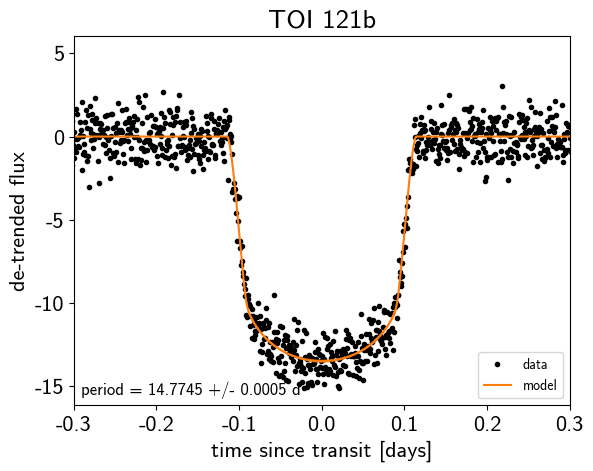

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

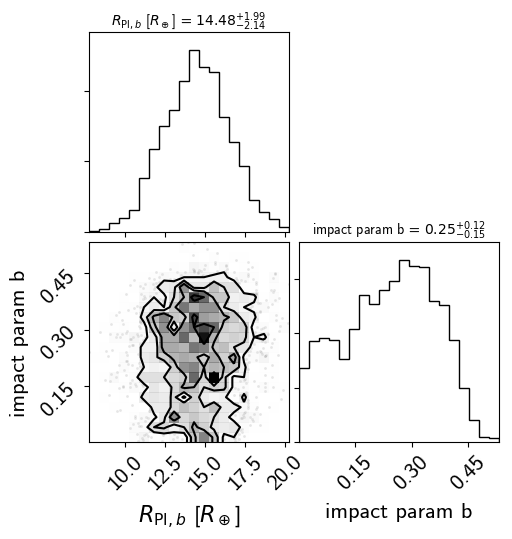

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

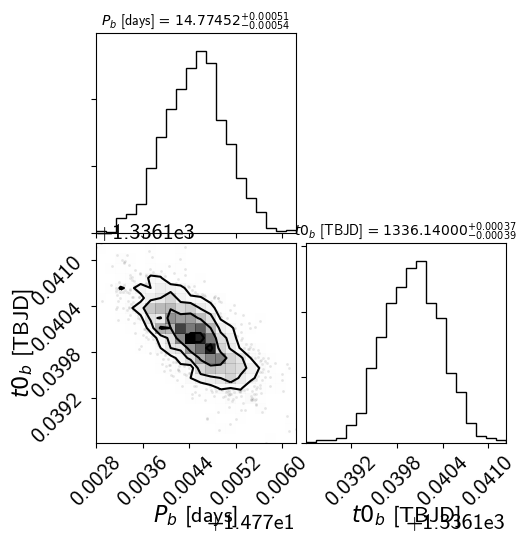

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

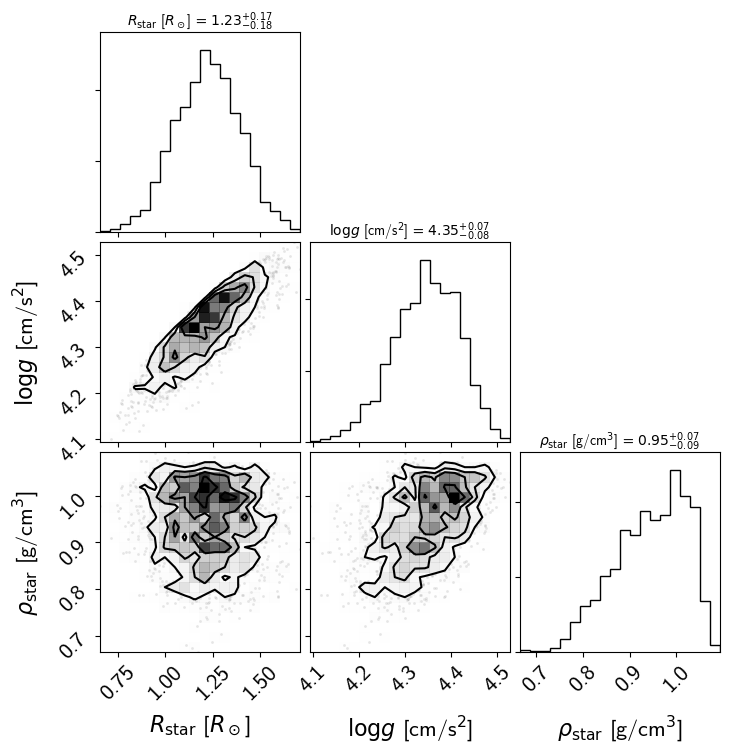

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3